In [1]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
np.random.seed(1234)

In [2]:
#Ground truth data distribution
def random_sample(d, Delta, N):
    y = np.ones(N)
    x = np.zeros((N,d))
    successes = np.random.binomial(N, 0.5)
    y[successes:] *= -1
    x[:successes, :] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*d), successes)
    x[successes:, :] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*d), N-successes)
    #x = np.take(x,np.random.rand(x.shape[0]).argsort(),axis=0,out=x)
    
    return x.reshape(N,d),y

In [3]:
#non-monotone activation function
def sigma_nm(t):
    if t < 0:
        return -2.5
    elif t>1.5:
        return 7.5
    elif 0<=t<=0.5:
        return (-4+2.5)/(0.5)*(t)-2.5
    elif 0.5<=t<=1.5:
        return (11.5)*(t-0.5)-4
        
def grad_sigma_nm(t):
    if t < 0:
        return 0
    elif t>1.5:
        return 0
    elif 0<=t<=0.5:
        return (-4+2.5)/(0.5)
    elif 0.5<=t<=1.5:
        return 11.5
vgrad_sigma_nm = np.vectorize(grad_sigma_nm)
vsigma_nm = np.vectorize(sigma_nm)

In [128]:
#two layer neural net with non-monotone activation
def neural_net_nm(x, θ):
    n = x.shape[0]
    out = vsigma_nm(θ@x.T)
    return np.mean(out, axis = 0).reshape(n,1)

In [124]:
def stochastic_gradient_descent(d, Delta, N, kappa, epsilon = 1e-5, num_epochs = 1000):
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)
    indices = [int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 60))]
    risk = []
    steps = epsilon*(epsilon*np.arange(1,num_epochs+1))**(-0.25)
    mean_dist = []
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        X = sample[0].reshape(1,d)
        y = sample[1]
        vgrad = vgrad_sigma_nm(weights@X.T)
        gradient = vgrad.reshape(N,1)*(X).reshape(1,d)
        weights += 2*steps[epoch-1]*(y-neural_net_nm(X, weights))*gradient
        if epoch in indices:
        #population risk
            M = int(1e4)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample-neural_net_nm(x_sample,weights))**2)
            risk.append(mse)
            dist = np.mean(np.linalg.norm(weights, axis = 0))
            mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_dist, indices

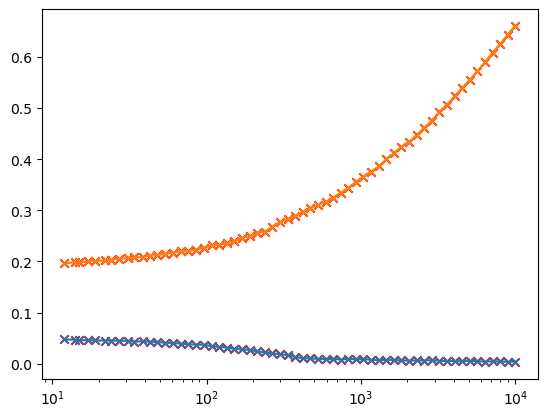

In [119]:
indices = [int(a) for a in 10**(np.linspace(1.1, 4, 60))]

fig, ax = plt.subplots()
ax.scatter(indices, mean_dist_sgd_1, marker = 'x', c = 'r')
ax.plot(indices, mean_dist_sgd_1, marker = 'x')
ax.scatter(indices, mean_dist_sgd_4, marker = 'x', c = 'r')
ax.plot(indices, mean_dist_sgd_4, marker = 'x')
ax.set_xscale('log')
plt.show()

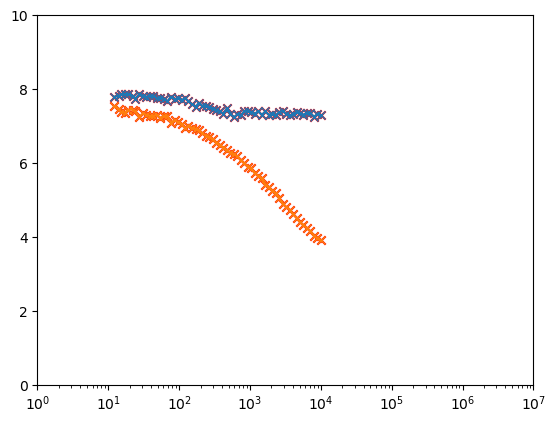

In [120]:
indices = [int(a) for a in 10**(np.linspace(1.1, 4, 60))]

fig, ax = plt.subplots()
ax.scatter(indices, risk_1, marker = 'x', c = 'r')
ax.plot(indices, risk_1, marker = 'x')
ax.scatter(indices, risk_4, marker = 'x', c = 'r')
ax.plot(indices, risk_4,  marker = 'x')
ax.set_xscale('log')
ax.set_ylim([0,10])
ax.set_xlim([1, 1e7])
plt.show()

In [125]:
from scipy.stats import norm

def q_plus(t, Delta):
    if t>0.01:
        x = np.linspace(0, 1.5/((1+Delta)*t), 1000)
        f = 1 / (np.sqrt(2 * np.pi)) * vsigma_nm((1 + Delta) * t * x) * np.exp(-x ** 2 / 2)
        integral = np.trapz(f, x)
        return integral -2.5*0.5+7.5*(1-norm.cdf(1.5/((1+Delta)*t)))
    else:
        g = np.random.normal(0,1,100)
        return np.mean(vsigma_nm((1+Delta)*t*g))

def q_minus(t, Delta):
    if t > 0.01:
        x = np.linspace(0, 1.5/((1-Delta)*t), 1000)
        f = 1 / (np.sqrt(2 * np.pi)) * vsigma_nm((1 - Delta) * t * x) * np.exp(-x ** 2 / 2)
        integral = np.trapz(f, x)
        return integral -2.5*0.5+7.5*(1-norm.cdf(1.5/((1-Delta)*t)))
    else:
        g = np.random.normal(0,1,100)
        return np.mean(vsigma_nm((1-Delta)*t*g))
    #return integral

vq_plus = np.vectorize(q_plus)
vq_minus = np.vectorize(q_minus)

def dq_plus(t, Delta):
    x1 = np.linspace(0, 0.5/((1+Delta)*t), 100)
    f1 = (1+Delta) / (np.sqrt(2 * np.pi)) * (-4+2.5)/(0.5) * np.exp(-x1 ** 2 / 2)*x1
    integral1 = np.trapz(f1, x1)
    x2 = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f2 = (1+Delta) / (np.sqrt(2 * np.pi)) * 11.5 * np.exp(-x2 ** 2 / 2)*x2
    integral2 = np.trapz(f2, x2)
    return integral1+integral2

def dq_minus(t, Delta):
    x1 = np.linspace(0, 0.5/((1-Delta)*t), 100)
    f1 = (1-Delta) / (np.sqrt(2 * np.pi)) * (-4+2.5)/(0.5) * np.exp(-x1 ** 2 / 2)*x1
    integral1 = np.trapz(f1, x1)
    x2 = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f2 = (1-Delta) / (np.sqrt(2 * np.pi)) * 11.5 * np.exp(-x2 ** 2 / 2)*x2
    integral2 = np.trapz(f2, x2)
    return integral1+integral2
    
vdq_plus = np.vectorize(dq_plus)
vdq_minus = np.vectorize(dq_minus)

def q_func(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus(t,0.8)
    elif flag == 1:
        return vq_minus(t,0.8)
    elif flag == 2:
        return vdq_plus(t,0.8)
    elif flag == 3:
        return vdq_minus(t,0.8)
    
def q_func_new(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus_new(t)
    elif flag == 1:
        return vq_minus_new(t)
    elif flag == 2:
        return vdq_plus_new(t)
    elif flag == 3:
        return vdq_minus_new(t)

def parallelise(t):
    with Pool(4) as p:
        results = np.array(p.map(q_func_new, [[t,0], [t,1], [t,2], [t,3]]))
    return results
vparallelise = np.vectorize(parallelise)

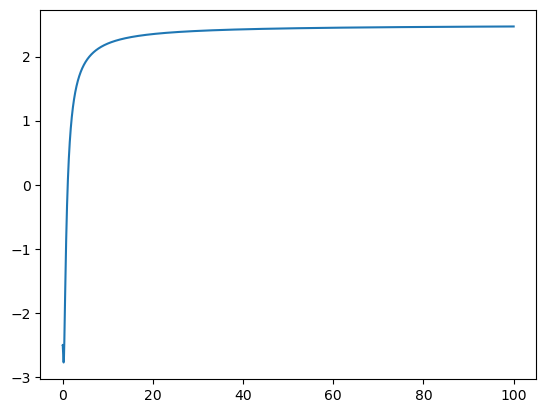

In [126]:
epsilon = 1e-5
Delta = 0.5
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_plus_vals = vq_plus(Interval_q, Delta)
plt.plot(Interval_q, q_plus_vals)

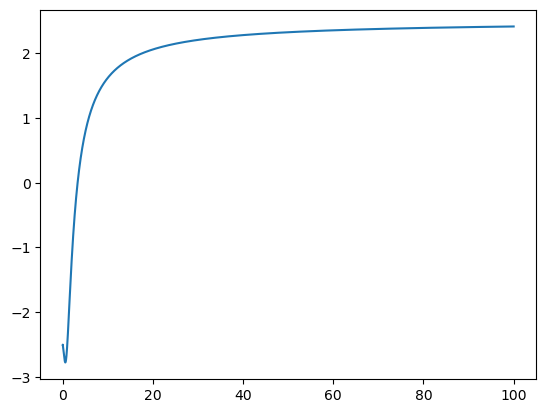

In [10]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_minus_vals = vq_minus(Interval_q, Delta)
plt.plot(Interval_q, q_minus_vals)

In [11]:
Q_plus = dict(zip(Interval_q, q_plus_vals))
Q_minus = dict(zip(Interval_q, q_minus_vals))

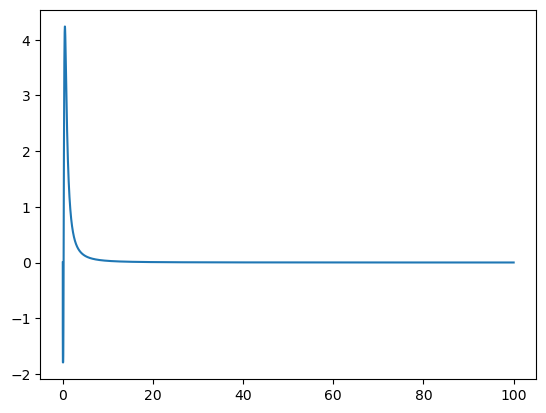

In [12]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_plus_vals = vdq_plus(Interval_q, Delta)
plt.plot(Interval_q, dq_plus_vals)

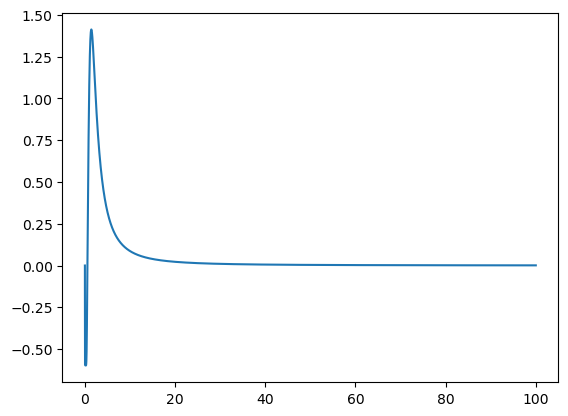

In [13]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_minus_vals = vdq_minus(Interval_q, Delta)
plt.plot(Interval_q, dq_minus_vals)

In [14]:
dQ_plus = dict(zip(Interval_q, dq_plus_vals))
dQ_minus = dict(zip(Interval_q, dq_minus_vals))

In [15]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
vfind_nearest = np.vectorize(find_nearest)

In [16]:
def q_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_plus[r_approx]

def q_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_minus[r_approx]

vq_plus_new = np.vectorize(q_plus_new)
vq_minus_new = np.vectorize(q_minus_new)

def dq_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_plus[r_approx]

def dq_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_minus[r_approx]

vdq_plus_new = np.vectorize(dq_plus_new)
vdq_minus_new = np.vectorize(dq_minus_new)


def R_inf(vq_plus, vq_minus, Delta):
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return 0.5 * (1 - mean_vq_plus) ** 2 + 0.5 * (1 + mean_vq_minus) ** 2

def grad_R_inf(r, vq_plus, vq_minus, dplus, dminus, Delta):
    J = len(r)
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return -1 / J * dplus * (1 - mean_vq_plus) + 1 / J * dminus * (1 + mean_vq_minus)

def update(r, dt, grad):
    J = len(r)
    return J * grad * dt

In [44]:
#simulate pde
def pde_sim(kappa, d, J, epsilon = 1e-5, Delta = 0.5):
    Interval = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e4))
    separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]
    processes_count = 4
    risk = np.zeros(Interval.shape[0])
    Z = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), J).reshape(J, d)
    r = np.linalg.norm(Z, axis = 1)
    mean_dist = []
    for k in trange(len(separations)):
        dt = separations[k]
        plus = vq_plus(r, Delta)
        minus = vq_minus(r, Delta)
        dplus = vdq_plus(r, Delta)
        dminus = vdq_minus(r, Delta)
        '''
        output = parallelise(r).reshape(4,J)
        plus = output[0]
        minus = output[1]
        dplus = output[2]
        dminus = output[3]
        '''
        inf_risk = R_inf(plus, minus, Delta)
        risk[k] = inf_risk
        d = np.mean(r)
        mean_dist.append(d)
        print('Epoch: {}, dist: {}'.format(k, inf_risk))
        grad = grad_R_inf(r, plus, minus, dplus, dminus, Delta)
        r = r - (Interval[k])**(-0.25)*update(r,dt, grad)
    plus = vq_plus(r, Delta)
    minus = vq_minus(r, Delta)
    inf_risk = R_inf(plus, minus, Delta)
    risk[-1] = inf_risk
    mean_dist.append(np.mean(r))
    return risk, mean_dist

In [127]:
pde_risk_1, mean_dist_pde_1 = pde_sim(0.1, 320, 1, epsilon = 1e-5, Delta = 0.5)
pde_risk_4, mean_dist_pde_4 = pde_sim(0.4, 320, 1, epsilon = 1e-5, Delta = 0.5)

  0%|          | 0/9999 [00:00<?, ?it/s]

Epoch: 0, dist: 7.9888084526855
Epoch: 1, dist: 7.988808447881884
Epoch: 2, dist: 7.988808443068304
Epoch: 3, dist: 7.988808438244734
Epoch: 4, dist: 7.988808433411159
Epoch: 5, dist: 7.9888084285675545
Epoch: 6, dist: 7.988808423713904
Epoch: 7, dist: 7.988808418850178
Epoch: 8, dist: 7.988808413976367
Epoch: 9, dist: 7.988808409092441
Epoch: 10, dist: 7.988808404198384
Epoch: 11, dist: 7.9888083992941725
Epoch: 12, dist: 7.988808394379786
Epoch: 13, dist: 7.988808389455206
Epoch: 14, dist: 7.988808384520408
Epoch: 15, dist: 7.988808379575371
Epoch: 16, dist: 7.988808374620074
Epoch: 17, dist: 7.988808369654498
Epoch: 18, dist: 7.9888083646786185
Epoch: 19, dist: 7.988808359692414
Epoch: 20, dist: 7.98880835469587
Epoch: 21, dist: 7.988808349688957
Epoch: 22, dist: 7.9888083446716545
Epoch: 23, dist: 7.988808339643944
Epoch: 24, dist: 7.988808334605802
Epoch: 25, dist: 7.98880832955721
Epoch: 26, dist: 7.988808324498141
Epoch: 27, dist: 7.988808319428575
Epoch: 28, dist: 7.98880831434

Epoch: 270, dist: 7.98880671630127
Epoch: 271, dist: 7.988806707895203
Epoch: 272, dist: 7.988806699471695
Epoch: 273, dist: 7.988806691030713
Epoch: 274, dist: 7.988806682572216
Epoch: 275, dist: 7.988806674096171
Epoch: 276, dist: 7.988806665602542
Epoch: 277, dist: 7.988806657091292
Epoch: 278, dist: 7.988806648562381
Epoch: 279, dist: 7.988806640015779
Epoch: 280, dist: 7.988806631451444
Epoch: 281, dist: 7.988806622869339
Epoch: 282, dist: 7.98880661426943
Epoch: 283, dist: 7.9888066056516776
Epoch: 284, dist: 7.9888065970160484
Epoch: 285, dist: 7.988806588362503
Epoch: 286, dist: 7.988806579691001
Epoch: 287, dist: 7.988806571001511
Epoch: 288, dist: 7.988806562293996
Epoch: 289, dist: 7.98880655356841
Epoch: 290, dist: 7.988806544824723
Epoch: 291, dist: 7.988806536062896
Epoch: 292, dist: 7.988806527282892
Epoch: 293, dist: 7.988806518484671
Epoch: 294, dist: 7.988806509668197
Epoch: 295, dist: 7.988806500833429
Epoch: 296, dist: 7.988806491980335
Epoch: 297, dist: 7.988806483

Epoch: 527, dist: 7.988803866205725
Epoch: 528, dist: 7.988803851886601
Epoch: 529, dist: 7.988803837537768
Epoch: 530, dist: 7.988803823159165
Epoch: 531, dist: 7.988803808750733
Epoch: 532, dist: 7.988803794312408
Epoch: 533, dist: 7.988803779844126
Epoch: 534, dist: 7.988803765345832
Epoch: 535, dist: 7.988803750817451
Epoch: 536, dist: 7.988803736258932
Epoch: 537, dist: 7.988803721670208
Epoch: 538, dist: 7.988803707051217
Epoch: 539, dist: 7.988803692401895
Epoch: 540, dist: 7.988803677722183
Epoch: 541, dist: 7.988803663012013
Epoch: 542, dist: 7.988803648271325
Epoch: 543, dist: 7.988803633500052
Epoch: 544, dist: 7.988803618698137
Epoch: 545, dist: 7.988803603865512
Epoch: 546, dist: 7.988803589002114
Epoch: 547, dist: 7.9888035741078784
Epoch: 548, dist: 7.98880355918274
Epoch: 549, dist: 7.988803544226638
Epoch: 550, dist: 7.988803529239508
Epoch: 551, dist: 7.988803514221282
Epoch: 552, dist: 7.988803499171899
Epoch: 553, dist: 7.988803484091294
Epoch: 554, dist: 7.98880346

Epoch: 774, dist: 7.988799252428804
Epoch: 775, dist: 7.988799228537522
Epoch: 776, dist: 7.988799204596669
Epoch: 777, dist: 7.988799180606147
Epoch: 778, dist: 7.988799156565854
Epoch: 779, dist: 7.988799132475684
Epoch: 780, dist: 7.988799108335534
Epoch: 781, dist: 7.9887990841453
Epoch: 782, dist: 7.9887990599048795
Epoch: 783, dist: 7.988799035614166
Epoch: 784, dist: 7.988799011273061
Epoch: 785, dist: 7.98879898688145
Epoch: 786, dist: 7.988798962439238
Epoch: 787, dist: 7.988798937946315
Epoch: 788, dist: 7.988798913402577
Epoch: 789, dist: 7.988798888807915
Epoch: 790, dist: 7.98879886416223
Epoch: 791, dist: 7.988798839465414
Epoch: 792, dist: 7.988798814717357
Epoch: 793, dist: 7.988798789917957
Epoch: 794, dist: 7.988798765067105
Epoch: 795, dist: 7.988798740164693
Epoch: 796, dist: 7.988798715210619
Epoch: 797, dist: 7.9887986902047725
Epoch: 798, dist: 7.988798665147048
Epoch: 799, dist: 7.988798640037332
Epoch: 800, dist: 7.988798614875524
Epoch: 801, dist: 7.9887985896

Epoch: 1007, dist: 7.988792103878441
Epoch: 1008, dist: 7.988792065156092
Epoch: 1009, dist: 7.988792026353407
Epoch: 1010, dist: 7.988791987470217
Epoch: 1011, dist: 7.988791948506358
Epoch: 1012, dist: 7.988791909461656
Epoch: 1013, dist: 7.988791870335952
Epoch: 1014, dist: 7.988791831129074
Epoch: 1015, dist: 7.988791791840852
Epoch: 1016, dist: 7.988791752471121
Epoch: 1017, dist: 7.988791713019708
Epoch: 1018, dist: 7.988791673486444
Epoch: 1019, dist: 7.9887916338711635
Epoch: 1020, dist: 7.98879159417369
Epoch: 1021, dist: 7.988791554393859
Epoch: 1022, dist: 7.988791514531496
Epoch: 1023, dist: 7.988791474586428
Epoch: 1024, dist: 7.9887914345584905
Epoch: 1025, dist: 7.988791394447505
Epoch: 1026, dist: 7.988791354253301
Epoch: 1027, dist: 7.988791313975705
Epoch: 1028, dist: 7.988791273614548
Epoch: 1029, dist: 7.988791233169651
Epoch: 1030, dist: 7.988791192640845
Epoch: 1031, dist: 7.988791152027953
Epoch: 1032, dist: 7.988791111330801
Epoch: 1033, dist: 7.9887910705492144

Epoch: 1229, dist: 7.988781199536452
Epoch: 1230, dist: 7.988781138190833
Epoch: 1231, dist: 7.988781076717942
Epoch: 1232, dist: 7.988781015117512
Epoch: 1233, dist: 7.98878095338928
Epoch: 1234, dist: 7.98878089153298
Epoch: 1235, dist: 7.988780829548345
Epoch: 1236, dist: 7.988780767435111
Epoch: 1237, dist: 7.988780705193009
Epoch: 1238, dist: 7.988780642821775
Epoch: 1239, dist: 7.988780580321139
Epoch: 1240, dist: 7.988780517690829
Epoch: 1241, dist: 7.988780454930582
Epoch: 1242, dist: 7.988780392040126
Epoch: 1243, dist: 7.98878032901919
Epoch: 1244, dist: 7.988780265867504
Epoch: 1245, dist: 7.988780202584795
Epoch: 1246, dist: 7.988780139170795
Epoch: 1247, dist: 7.988780075625229
Epoch: 1248, dist: 7.988780011947826
Epoch: 1249, dist: 7.988779948138307
Epoch: 1250, dist: 7.988779884196405
Epoch: 1251, dist: 7.9887798201218425
Epoch: 1252, dist: 7.988779755914344
Epoch: 1253, dist: 7.988779691573632
Epoch: 1254, dist: 7.988779627099435
Epoch: 1255, dist: 7.988779562491468
Epo

Epoch: 1495, dist: 7.9887594517667235
Epoch: 1496, dist: 7.988759345300659
Epoch: 1497, dist: 7.988759238613704
Epoch: 1498, dist: 7.988759131705402
Epoch: 1499, dist: 7.988759024575299
Epoch: 1500, dist: 7.988758917222928
Epoch: 1501, dist: 7.988758809647832
Epoch: 1502, dist: 7.9887587018495445
Epoch: 1503, dist: 7.9887585938276064
Epoch: 1504, dist: 7.988758485581551
Epoch: 1505, dist: 7.9887583771109165
Epoch: 1506, dist: 7.988758268415235
Epoch: 1507, dist: 7.988758159494039
Epoch: 1508, dist: 7.988758050346862
Epoch: 1509, dist: 7.988757940973232
Epoch: 1510, dist: 7.988757831372684
Epoch: 1511, dist: 7.988757721544747
Epoch: 1512, dist: 7.9887576114889445
Epoch: 1513, dist: 7.988757501204805
Epoch: 1514, dist: 7.98875739069186
Epoch: 1515, dist: 7.988757279949628
Epoch: 1516, dist: 7.988757168977636
Epoch: 1517, dist: 7.988757057775406
Epoch: 1518, dist: 7.988756946342465
Epoch: 1519, dist: 7.98875683467833
Epoch: 1520, dist: 7.9887567227825205
Epoch: 1521, dist: 7.9887566106545

Epoch: 1720, dist: 7.988728963397829
Epoch: 1721, dist: 7.988728793676401
Epoch: 1722, dist: 7.988728623602841
Epoch: 1723, dist: 7.988728453176424
Epoch: 1724, dist: 7.988728282396412
Epoch: 1725, dist: 7.988728111262077
Epoch: 1726, dist: 7.9887279397726765
Epoch: 1727, dist: 7.9887277679274815
Epoch: 1728, dist: 7.988727595725752
Epoch: 1729, dist: 7.988727423166745
Epoch: 1730, dist: 7.98872725024972
Epoch: 1731, dist: 7.988727076973936
Epoch: 1732, dist: 7.988726903338648
Epoch: 1733, dist: 7.988726729343108
Epoch: 1734, dist: 7.988726554986572
Epoch: 1735, dist: 7.988726380268292
Epoch: 1736, dist: 7.988726205187512
Epoch: 1737, dist: 7.988726029743481
Epoch: 1738, dist: 7.98872585393545
Epoch: 1739, dist: 7.98872567776266
Epoch: 1740, dist: 7.988725501224354
Epoch: 1741, dist: 7.988725324319776
Epoch: 1742, dist: 7.988725147048166
Epoch: 1743, dist: 7.988724969408761
Epoch: 1744, dist: 7.988724791400794
Epoch: 1745, dist: 7.988724613023507
Epoch: 1746, dist: 7.988724434276133
Ep

Epoch: 1966, dist: 7.988674559376978
Epoch: 1967, dist: 7.9886742767796
Epoch: 1968, dist: 7.988673993595888
Epoch: 1969, dist: 7.988673709824629
Epoch: 1970, dist: 7.988673425464603
Epoch: 1971, dist: 7.988673140514587
Epoch: 1972, dist: 7.988672854973358
Epoch: 1973, dist: 7.988672568839693
Epoch: 1974, dist: 7.988672282112354
Epoch: 1975, dist: 7.988671994790115
Epoch: 1976, dist: 7.988671706871744
Epoch: 1977, dist: 7.988671418355999
Epoch: 1978, dist: 7.9886711292416415
Epoch: 1979, dist: 7.988670839527433
Epoch: 1980, dist: 7.988670549212125
Epoch: 1981, dist: 7.988670258294471
Epoch: 1982, dist: 7.988669966773219
Epoch: 1983, dist: 7.988669674647124
Epoch: 1984, dist: 7.988669381914924
Epoch: 1985, dist: 7.988669088575365
Epoch: 1986, dist: 7.988668794627184
Epoch: 1987, dist: 7.988668500069119
Epoch: 1988, dist: 7.988668204899906
Epoch: 1989, dist: 7.988667909118277
Epoch: 1990, dist: 7.98866761272296
Epoch: 1991, dist: 7.98866731571268
Epoch: 1992, dist: 7.988667018086167
Epoc

Epoch: 2213, dist: 7.988583501900486
Epoch: 2214, dist: 7.988583030374176
Epoch: 2215, dist: 7.988582557869516
Epoch: 2216, dist: 7.988582084384472
Epoch: 2217, dist: 7.988581609917002
Epoch: 2218, dist: 7.988581134465081
Epoch: 2219, dist: 7.988580658026655
Epoch: 2220, dist: 7.988580180599681
Epoch: 2221, dist: 7.988579702182106
Epoch: 2222, dist: 7.988579222771879
Epoch: 2223, dist: 7.988578742366935
Epoch: 2224, dist: 7.988578260965213
Epoch: 2225, dist: 7.988577778564645
Epoch: 2226, dist: 7.988577295163153
Epoch: 2227, dist: 7.988576810758668
Epoch: 2228, dist: 7.988576325349106
Epoch: 2229, dist: 7.988575838932376
Epoch: 2230, dist: 7.988575351506394
Epoch: 2231, dist: 7.988574863069065
Epoch: 2232, dist: 7.988574373618287
Epoch: 2233, dist: 7.988573883151961
Epoch: 2234, dist: 7.988573391667979
Epoch: 2235, dist: 7.988572899164225
Epoch: 2236, dist: 7.988572405638589
Epoch: 2237, dist: 7.988571911088948
Epoch: 2238, dist: 7.988571415513174
Epoch: 2239, dist: 7.9885709189091445


Epoch: 2448, dist: 7.988440881903002
Epoch: 2449, dist: 7.988440114450662
Epoch: 2450, dist: 7.988439345405874
Epoch: 2451, dist: 7.98843857476533
Epoch: 2452, dist: 7.988437802525714
Epoch: 2453, dist: 7.988437028683714
Epoch: 2454, dist: 7.988436253235999
Epoch: 2455, dist: 7.988435476179241
Epoch: 2456, dist: 7.988434697510099
Epoch: 2457, dist: 7.988433917225226
Epoch: 2458, dist: 7.988433135321272
Epoch: 2459, dist: 7.988432351794874
Epoch: 2460, dist: 7.988431566642664
Epoch: 2461, dist: 7.98843077986127
Epoch: 2462, dist: 7.988429991447314
Epoch: 2463, dist: 7.9884292013974
Epoch: 2464, dist: 7.988428409708138
Epoch: 2465, dist: 7.988427616376127
Epoch: 2466, dist: 7.988426821397957
Epoch: 2467, dist: 7.9884260247702095
Epoch: 2468, dist: 7.988425226489461
Epoch: 2469, dist: 7.9884244265522835
Epoch: 2470, dist: 7.988423624955237
Epoch: 2471, dist: 7.988422821694881
Epoch: 2472, dist: 7.98842201676776
Epoch: 2473, dist: 7.988421210170415
Epoch: 2474, dist: 7.988420401899379
Epoc

Epoch: 2733, dist: 7.988143010084041
Epoch: 2734, dist: 7.9881416245164285
Epoch: 2735, dist: 7.988140236073452
Epoch: 2736, dist: 7.988138844749139
Epoch: 2737, dist: 7.9881374505375105
Epoch: 2738, dist: 7.988136053432575
Epoch: 2739, dist: 7.988134653428327
Epoch: 2740, dist: 7.988133250518743
Epoch: 2741, dist: 7.9881318446978
Epoch: 2742, dist: 7.988130435959448
Epoch: 2743, dist: 7.988129024297631
Epoch: 2744, dist: 7.988127609706289
Epoch: 2745, dist: 7.9881261921793305
Epoch: 2746, dist: 7.988124771710669
Epoch: 2747, dist: 7.988123348294195
Epoch: 2748, dist: 7.9881219219237884
Epoch: 2749, dist: 7.98812049259332
Epoch: 2750, dist: 7.988119060296645
Epoch: 2751, dist: 7.988117625027604
Epoch: 2752, dist: 7.9881161867800285
Epoch: 2753, dist: 7.988114745547738
Epoch: 2754, dist: 7.988113301324533
Epoch: 2755, dist: 7.988111854104205
Epoch: 2756, dist: 7.988110403880534
Epoch: 2757, dist: 7.988108950647289
Epoch: 2758, dist: 7.988107494398214
Epoch: 2759, dist: 7.988106035127057

Epoch: 2994, dist: 7.9876637157369705
Epoch: 2995, dist: 7.9876613354339
Epoch: 2996, dist: 7.987658950190257
Epoch: 2997, dist: 7.987656559995775
Epoch: 2998, dist: 7.987654164840178
Epoch: 2999, dist: 7.98765176471316
Epoch: 3000, dist: 7.987649359604403
Epoch: 3001, dist: 7.987646949503557
Epoch: 3002, dist: 7.987644534400262
Epoch: 3003, dist: 7.987642114284124
Epoch: 3004, dist: 7.987639689144735
Epoch: 3005, dist: 7.987637258971666
Epoch: 3006, dist: 7.987634823754464
Epoch: 3007, dist: 7.9876323834826515
Epoch: 3008, dist: 7.987629938145737
Epoch: 3009, dist: 7.987627487733198
Epoch: 3010, dist: 7.987625032234497
Epoch: 3011, dist: 7.987622571639075
Epoch: 3012, dist: 7.987620105936344
Epoch: 3013, dist: 7.9876176351157
Epoch: 3014, dist: 7.987615159166513
Epoch: 3015, dist: 7.987612678078134
Epoch: 3016, dist: 7.9876101918398925
Epoch: 3017, dist: 7.987607700441096
Epoch: 3018, dist: 7.987605203871023
Epoch: 3019, dist: 7.987602702118937
Epoch: 3020, dist: 7.98760019517408
Epoc

Epoch: 3224, dist: 7.986962933752379
Epoch: 3225, dist: 7.986959098707887
Epoch: 3226, dist: 7.986955255701238
Epoch: 3227, dist: 7.986951404715885
Epoch: 3228, dist: 7.986947545735255
Epoch: 3229, dist: 7.9869436787427395
Epoch: 3230, dist: 7.986939803721686
Epoch: 3231, dist: 7.986935920655417
Epoch: 3232, dist: 7.986932029527223
Epoch: 3233, dist: 7.986928130320345
Epoch: 3234, dist: 7.986924223018004
Epoch: 3235, dist: 7.986920307603382
Epoch: 3236, dist: 7.9869163840596205
Epoch: 3237, dist: 7.986912452369832
Epoch: 3238, dist: 7.9869085125170916
Epoch: 3239, dist: 7.9869045644844405
Epoch: 3240, dist: 7.986900608254878
Epoch: 3241, dist: 7.98689664381138
Epoch: 3242, dist: 7.98689267113688
Epoch: 3243, dist: 7.986888690214275
Epoch: 3244, dist: 7.986884701026428
Epoch: 3245, dist: 7.986880703556163
Epoch: 3246, dist: 7.986876697786277
Epoch: 3247, dist: 7.986872683699524
Epoch: 3248, dist: 7.9868686612786215
Epoch: 3249, dist: 7.98686463050626
Epoch: 3250, dist: 7.986860591365078

Epoch: 3502, dist: 7.985522189281288
Epoch: 3503, dist: 7.985515362232174
Epoch: 3504, dist: 7.985508521001554
Epoch: 3505, dist: 7.985501665559941
Epoch: 3506, dist: 7.985494795877771
Epoch: 3507, dist: 7.985487911925433
Epoch: 3508, dist: 7.985481013673251
Epoch: 3509, dist: 7.985474101091483
Epoch: 3510, dist: 7.985467174150324
Epoch: 3511, dist: 7.985460232819914
Epoch: 3512, dist: 7.985453277070325
Epoch: 3513, dist: 7.985446306871569
Epoch: 3514, dist: 7.985439322193597
Epoch: 3515, dist: 7.985432323006288
Epoch: 3516, dist: 7.9854253092794725
Epoch: 3517, dist: 7.985418280982911
Epoch: 3518, dist: 7.985411238086294
Epoch: 3519, dist: 7.985404180559262
Epoch: 3520, dist: 7.9853971083713855
Epoch: 3521, dist: 7.985390021492173
Epoch: 3522, dist: 7.985382919891063
Epoch: 3523, dist: 7.985375803537444
Epoch: 3524, dist: 7.985368672400624
Epoch: 3525, dist: 7.985361526449861
Epoch: 3526, dist: 7.9853543656543415
Epoch: 3527, dist: 7.985347189983191
Epoch: 3528, dist: 7.98533999940546

Epoch: 3750, dist: 7.98331014667292
Epoch: 3751, dist: 7.983298722885094
Epoch: 3752, dist: 7.983287275349056
Epoch: 3753, dist: 7.983275804015349
Epoch: 3754, dist: 7.983264308834409
Epoch: 3755, dist: 7.983252789756571
Epoch: 3756, dist: 7.983241246732065
Epoch: 3757, dist: 7.983229679711018
Epoch: 3758, dist: 7.983218088643449
Epoch: 3759, dist: 7.983206473479277
Epoch: 3760, dist: 7.983194834168315
Epoch: 3761, dist: 7.983183170660273
Epoch: 3762, dist: 7.98317148290475
Epoch: 3763, dist: 7.9831597708512465
Epoch: 3764, dist: 7.983148034449153
Epoch: 3765, dist: 7.983136273647759
Epoch: 3766, dist: 7.983124488396238
Epoch: 3767, dist: 7.9831126786436695
Epoch: 3768, dist: 7.983100844339021
Epoch: 3769, dist: 7.983088985431153
Epoch: 3770, dist: 7.983077101868817
Epoch: 3771, dist: 7.983065193600663
Epoch: 3772, dist: 7.983053260575231
Epoch: 3773, dist: 7.983041302740949
Epoch: 3774, dist: 7.983029320046146
Epoch: 3775, dist: 7.983017312439035
Epoch: 3776, dist: 7.983005279867726
E

Epoch: 3999, dist: 7.979588666723187
Epoch: 4000, dist: 7.979569502001422
Epoch: 4001, dist: 7.979550297392945
Epoch: 4002, dist: 7.979531052814511
Epoch: 4003, dist: 7.979511768182714
Epoch: 4004, dist: 7.979492443413963
Epoch: 4005, dist: 7.979473078424494
Epoch: 4006, dist: 7.979453673130371
Epoch: 4007, dist: 7.979434227447478
Epoch: 4008, dist: 7.979414741291524
Epoch: 4009, dist: 7.979395214578043
Epoch: 4010, dist: 7.97937564722239
Epoch: 4011, dist: 7.979356039139739
Epoch: 4012, dist: 7.979336390245093
Epoch: 4013, dist: 7.979316700453275
Epoch: 4014, dist: 7.979296969678925
Epoch: 4015, dist: 7.979277197836513
Epoch: 4016, dist: 7.97925738484032
Epoch: 4017, dist: 7.979237530604451
Epoch: 4018, dist: 7.979217635042833
Epoch: 4019, dist: 7.979197698069205
Epoch: 4020, dist: 7.979177719597141
Epoch: 4021, dist: 7.979157699540014
Epoch: 4022, dist: 7.979137637811034
Epoch: 4023, dist: 7.97911753432321
Epoch: 4024, dist: 7.979097388989385
Epoch: 4025, dist: 7.979077201722213
Epoc

Epoch: 4249, dist: 7.973310971714437
Epoch: 4250, dist: 7.973278730432434
Epoch: 4251, dist: 7.973246421938435
Epoch: 4252, dist: 7.973214046091835
Epoch: 4253, dist: 7.973181602751728
Epoch: 4254, dist: 7.973149091776909
Epoch: 4255, dist: 7.973116513025885
Epoch: 4256, dist: 7.973083866356857
Epoch: 4257, dist: 7.973051151627738
Epoch: 4258, dist: 7.973018368696133
Epoch: 4259, dist: 7.972985517419346
Epoch: 4260, dist: 7.972952597654393
Epoch: 4261, dist: 7.972919609257978
Epoch: 4262, dist: 7.972886552086512
Epoch: 4263, dist: 7.972853425996098
Epoch: 4264, dist: 7.9728202308425375
Epoch: 4265, dist: 7.972786966481335
Epoch: 4266, dist: 7.9727536327676845
Epoch: 4267, dist: 7.972720229556475
Epoch: 4268, dist: 7.972686756702298
Epoch: 4269, dist: 7.972653214059428
Epoch: 4270, dist: 7.972619601481847
Epoch: 4271, dist: 7.972585918823219
Epoch: 4272, dist: 7.9725521659369045
Epoch: 4273, dist: 7.972518342675959
Epoch: 4274, dist: 7.972484448893121
Epoch: 4275, dist: 7.97245048444082

Epoch: 4510, dist: 7.962141146262517
Epoch: 4511, dist: 7.962085594729409
Epoch: 4512, dist: 7.9620299271629715
Epoch: 4513, dist: 7.9619741433200275
Epoch: 4514, dist: 7.961918242956896
Epoch: 4515, dist: 7.961862225829383
Epoch: 4516, dist: 7.961806091692779
Epoch: 4517, dist: 7.961749840301867
Epoch: 4518, dist: 7.961693471410911
Epoch: 4519, dist: 7.961636984773659
Epoch: 4520, dist: 7.961580380143355
Epoch: 4521, dist: 7.9615236572727035
Epoch: 4522, dist: 7.961466815913913
Epoch: 4523, dist: 7.961409855818657
Epoch: 4524, dist: 7.961352776738099
Epoch: 4525, dist: 7.96129557842287
Epoch: 4526, dist: 7.961238260623091
Epoch: 4527, dist: 7.961180823088348
Epoch: 4528, dist: 7.961123265567707
Epoch: 4529, dist: 7.961065587809709
Epoch: 4530, dist: 7.961007789562368
Epoch: 4531, dist: 7.960949870573165
Epoch: 4532, dist: 7.960891830589059
Epoch: 4533, dist: 7.9608336693564725
Epoch: 4534, dist: 7.9607753866212985
Epoch: 4535, dist: 7.960716982128905
Epoch: 4536, dist: 7.9606584556241

Epoch: 4756, dist: 7.944298661124189
Epoch: 4757, dist: 7.944205815355565
Epoch: 4758, dist: 7.9441127754647844
Epoch: 4759, dist: 7.944019541046163
Epoch: 4760, dist: 7.943926111693176
Epoch: 4761, dist: 7.943832486998457
Epoch: 4762, dist: 7.943738666553806
Epoch: 4763, dist: 7.943644649950175
Epoch: 4764, dist: 7.9435504367776835
Epoch: 4765, dist: 7.943456026625601
Epoch: 4766, dist: 7.943361419082353
Epoch: 4767, dist: 7.9432666137355135
Epoch: 4768, dist: 7.943171610171811
Epoch: 4769, dist: 7.943076407977127
Epoch: 4770, dist: 7.942981006736484
Epoch: 4771, dist: 7.942885406034056
Epoch: 4772, dist: 7.942789605453158
Epoch: 4773, dist: 7.942693604576247
Epoch: 4774, dist: 7.942597402984925
Epoch: 4775, dist: 7.942501000259934
Epoch: 4776, dist: 7.942404395981149
Epoch: 4777, dist: 7.942307589727582
Epoch: 4778, dist: 7.942210581077385
Epoch: 4779, dist: 7.94211336960784
Epoch: 4780, dist: 7.942015954895356
Epoch: 4781, dist: 7.941918336515478
Epoch: 4782, dist: 7.941820514042873

Epoch: 5002, dist: 7.914477544568077
Epoch: 5003, dist: 7.9143224116009945
Epoch: 5004, dist: 7.914166955186031
Epoch: 5005, dist: 7.914011174657022
Epoch: 5006, dist: 7.913855069346512
Epoch: 5007, dist: 7.913698638585722
Epoch: 5008, dist: 7.9135418817045675
Epoch: 5009, dist: 7.9133847980316485
Epoch: 5010, dist: 7.913227386894242
Epoch: 5011, dist: 7.913069647618314
Epoch: 5012, dist: 7.912911579528501
Epoch: 5013, dist: 7.912753181948118
Epoch: 5014, dist: 7.912594454199158
Epoch: 5015, dist: 7.912435395602282
Epoch: 5016, dist: 7.9122760054768175
Epoch: 5017, dist: 7.912116283140764
Epoch: 5018, dist: 7.911956227910788
Epoch: 5019, dist: 7.9117958391022105
Epoch: 5020, dist: 7.911635116029015
Epoch: 5021, dist: 7.911474058003851
Epoch: 5022, dist: 7.911312664338014
Epoch: 5023, dist: 7.911150934341455
Epoch: 5024, dist: 7.910988867322785
Epoch: 5025, dist: 7.910826462589251
Epoch: 5026, dist: 7.910663719446753
Epoch: 5027, dist: 7.9105006371998385
Epoch: 5028, dist: 7.91033721515

Epoch: 5251, dist: 7.863946749121093
Epoch: 5252, dist: 7.863686813563616
Epoch: 5253, dist: 7.863426342162729
Epoch: 5254, dist: 7.863165333849591
Epoch: 5255, dist: 7.862903787553386
Epoch: 5256, dist: 7.86264170220132
Epoch: 5257, dist: 7.86237907671861
Epoch: 5258, dist: 7.862115910028492
Epoch: 5259, dist: 7.861852201052214
Epoch: 5260, dist: 7.861587948709026
Epoch: 5261, dist: 7.861323151916192
Epoch: 5262, dist: 7.861057809588959
Epoch: 5263, dist: 7.860791920640593
Epoch: 5264, dist: 7.860525483982333
Epoch: 5265, dist: 7.860258498523424
Epoch: 5266, dist: 7.8599909631710805
Epoch: 5267, dist: 7.859722876830521
Epoch: 5268, dist: 7.859454238404922
Epoch: 5269, dist: 7.859185046795455
Epoch: 5270, dist: 7.858915300901244
Epoch: 5271, dist: 7.858644999619403
Epoch: 5272, dist: 7.858374141844991
Epoch: 5273, dist: 7.858102726471047
Epoch: 5274, dist: 7.8578307523885496
Epoch: 5275, dist: 7.857558218486448
Epoch: 5276, dist: 7.857285123651635
Epoch: 5277, dist: 7.857011466768947
E

Epoch: 5508, dist: 7.776142055209098
Epoch: 5509, dist: 7.77570301893476
Epoch: 5510, dist: 7.775263095616619
Epoch: 5511, dist: 7.774822283534401
Epoch: 5512, dist: 7.774380580964602
Epoch: 5513, dist: 7.773937986180501
Epoch: 5514, dist: 7.7734944974521625
Epoch: 5515, dist: 7.773050113046404
Epoch: 5516, dist: 7.772604831226817
Epoch: 5517, dist: 7.77215865025374
Epoch: 5518, dist: 7.771711568384273
Epoch: 5519, dist: 7.771263583872255
Epoch: 5520, dist: 7.770814694968261
Epoch: 5521, dist: 7.770364899919609
Epoch: 5522, dist: 7.769914196970341
Epoch: 5523, dist: 7.769462584361224
Epoch: 5524, dist: 7.769010060329733
Epoch: 5525, dist: 7.768556623110067
Epoch: 5526, dist: 7.768102270933124
Epoch: 5527, dist: 7.767647002026502
Epoch: 5528, dist: 7.767190814614494
Epoch: 5529, dist: 7.766733706918085
Epoch: 5530, dist: 7.766275677154936
Epoch: 5531, dist: 7.765816723539395
Epoch: 5532, dist: 7.765356844282474
Epoch: 5533, dist: 7.764896037591852
Epoch: 5534, dist: 7.7644343016718755
E

Epoch: 5768, dist: 7.62649631583073
Epoch: 5769, dist: 7.625758460042519
Epoch: 5770, dist: 7.625019147328195
Epoch: 5771, dist: 7.624278374975209
Epoch: 5772, dist: 7.623536140266778
Epoch: 5773, dist: 7.622792440481862
Epoch: 5774, dist: 7.622047272895191
Epoch: 5775, dist: 7.621300634777244
Epoch: 5776, dist: 7.620552523394257
Epoch: 5777, dist: 7.619802936008217
Epoch: 5778, dist: 7.619051869876875
Epoch: 5779, dist: 7.618299322253728
Epoch: 5780, dist: 7.617545290388027
Epoch: 5781, dist: 7.616789771524775
Epoch: 5782, dist: 7.61603276290473
Epoch: 5783, dist: 7.615274261764407
Epoch: 5784, dist: 7.614514265336067
Epoch: 5785, dist: 7.613752770847725
Epoch: 5786, dist: 7.612989775523152
Epoch: 5787, dist: 7.612225276581872
Epoch: 5788, dist: 7.611459271239159
Epoch: 5789, dist: 7.610691756706048
Epoch: 5790, dist: 7.609922730189321
Epoch: 5791, dist: 7.609152188891516
Epoch: 5792, dist: 7.608380130010933
Epoch: 5793, dist: 7.6076065507416235
Epoch: 5794, dist: 7.6068314482734
Epoc

Epoch: 6040, dist: 7.36229998172502
Epoch: 6041, dist: 7.3610568353009835
Epoch: 6042, dist: 7.359811526599992
Epoch: 6043, dist: 7.358564059822595
Epoch: 6044, dist: 7.357314439585453
Epoch: 6045, dist: 7.356062670948477
Epoch: 6046, dist: 7.354808759444143
Epoch: 6047, dist: 7.353552711109112
Epoch: 6048, dist: 7.352294532518416
Epoch: 6049, dist: 7.351034230822444
Epoch: 6050, dist: 7.3497718137870045
Epoch: 6051, dist: 7.348507289836754
Epoch: 6052, dist: 7.347240668102362
Epoch: 6053, dist: 7.345971958471763
Epoch: 6054, dist: 7.344701171645921
Epoch: 6055, dist: 7.343428319199616
Epoch: 6056, dist: 7.342153413647734
Epoch: 6057, dist: 7.340876468517713
Epoch: 6058, dist: 7.339597498428805
Epoch: 6059, dist: 7.338316519178905
Epoch: 6060, dist: 7.337033547839859
Epoch: 6061, dist: 7.335748602862201
Epoch: 6062, dist: 7.334461704190478
Epoch: 6063, dist: 7.333172873390426
Epoch: 6064, dist: 7.331882133789515
Epoch: 6065, dist: 7.330589510632478
Epoch: 6066, dist: 7.329295031253908


Epoch: 6299, dist: 7.256644401330487
Epoch: 6300, dist: 7.255798968203996
Epoch: 6301, dist: 7.255415745554592
Epoch: 6302, dist: 7.254698279148077
Epoch: 6303, dist: 7.255190506260556
Epoch: 6304, dist: 7.255097017442287
Epoch: 6305, dist: 7.255374420491951
Epoch: 6306, dist: 7.255193415330745
Epoch: 6307, dist: 7.255318776727514
Epoch: 6308, dist: 7.257155307537411
Epoch: 6309, dist: 7.254882538621413
Epoch: 6310, dist: 7.255570013018211
Epoch: 6311, dist: 7.256369698746764
Epoch: 6312, dist: 7.2561021380156525
Epoch: 6313, dist: 7.25591307162189
Epoch: 6314, dist: 7.2552388846111535
Epoch: 6315, dist: 7.2569525298855755
Epoch: 6316, dist: 7.2569087008559485
Epoch: 6317, dist: 7.254394329060093
Epoch: 6318, dist: 7.255818545344177
Epoch: 6319, dist: 7.254296373784143
Epoch: 6320, dist: 7.257016468945782
Epoch: 6321, dist: 7.255982146744613
Epoch: 6322, dist: 7.255947169489838
Epoch: 6323, dist: 7.2552374625731835
Epoch: 6324, dist: 7.254426276059969
Epoch: 6325, dist: 7.2550602488805

Epoch: 6633, dist: 7.255180611691664
Epoch: 6634, dist: 7.254684628788694
Epoch: 6635, dist: 7.253923349526303
Epoch: 6636, dist: 7.256270540792194
Epoch: 6637, dist: 7.255594643582442
Epoch: 6638, dist: 7.255062575115824
Epoch: 6639, dist: 7.254775449471926
Epoch: 6640, dist: 7.254853459662394
Epoch: 6641, dist: 7.255047266755996
Epoch: 6642, dist: 7.254590195276315
Epoch: 6643, dist: 7.254876769284808
Epoch: 6644, dist: 7.254052144245564
Epoch: 6645, dist: 7.25378194081129
Epoch: 6646, dist: 7.254548704726089
Epoch: 6647, dist: 7.2547529074848045
Epoch: 6648, dist: 7.255261960847896
Epoch: 6649, dist: 7.256157726619397
Epoch: 6650, dist: 7.254421030357124
Epoch: 6651, dist: 7.2552667423533235
Epoch: 6652, dist: 7.254984544185555
Epoch: 6653, dist: 7.25574882828537
Epoch: 6654, dist: 7.25471863688243
Epoch: 6655, dist: 7.254859382668789
Epoch: 6656, dist: 7.254226389968993
Epoch: 6657, dist: 7.254064266869964
Epoch: 6658, dist: 7.256237530315636
Epoch: 6659, dist: 7.25467759430285
Epo

Epoch: 6977, dist: 7.254921857797139
Epoch: 6978, dist: 7.254502121927293
Epoch: 6979, dist: 7.2548745968462915
Epoch: 6980, dist: 7.2550883262964945
Epoch: 6981, dist: 7.25468834416346
Epoch: 6982, dist: 7.254836115202412
Epoch: 6983, dist: 7.255006567248352
Epoch: 6984, dist: 7.254761485610194
Epoch: 6985, dist: 7.255078729300795
Epoch: 6986, dist: 7.255260826821994
Epoch: 6987, dist: 7.254609711721427
Epoch: 6988, dist: 7.253913690005032
Epoch: 6989, dist: 7.253997311842562
Epoch: 6990, dist: 7.254275427160461
Epoch: 6991, dist: 7.255166748210627
Epoch: 6992, dist: 7.256285326996172
Epoch: 6993, dist: 7.254893503358073
Epoch: 6994, dist: 7.25476883485141
Epoch: 6995, dist: 7.254901408031403
Epoch: 6996, dist: 7.255484082040679
Epoch: 6997, dist: 7.254972150637586
Epoch: 6998, dist: 7.254873466670891
Epoch: 6999, dist: 7.254377934101584
Epoch: 7000, dist: 7.254284475911694
Epoch: 7001, dist: 7.254485771773311
Epoch: 7002, dist: 7.254680458537662
Epoch: 7003, dist: 7.255243988344971
E

Epoch: 7322, dist: 7.255038797710301
Epoch: 7323, dist: 7.255492283124136
Epoch: 7324, dist: 7.255016262183338
Epoch: 7325, dist: 7.255210343318097
Epoch: 7326, dist: 7.2542345260007295
Epoch: 7327, dist: 7.254275406480267
Epoch: 7328, dist: 7.254203785581623
Epoch: 7329, dist: 7.254206376105187
Epoch: 7330, dist: 7.254518129982719
Epoch: 7331, dist: 7.254089298290918
Epoch: 7332, dist: 7.254296983405853
Epoch: 7333, dist: 7.254315752955122
Epoch: 7334, dist: 7.254227971814587
Epoch: 7335, dist: 7.2534017325060125
Epoch: 7336, dist: 7.254649148452884
Epoch: 7337, dist: 7.254436137465385
Epoch: 7338, dist: 7.254268076193179
Epoch: 7339, dist: 7.255062403584986
Epoch: 7340, dist: 7.2551983512020835
Epoch: 7341, dist: 7.253935184808626
Epoch: 7342, dist: 7.254070745206893
Epoch: 7343, dist: 7.2545485538668135
Epoch: 7344, dist: 7.253953265987621
Epoch: 7345, dist: 7.254822318156615
Epoch: 7346, dist: 7.253037505387908
Epoch: 7347, dist: 7.25504387958374
Epoch: 7348, dist: 7.25389167160119

Epoch: 7658, dist: 7.2542717961702605
Epoch: 7659, dist: 7.253901913146905
Epoch: 7660, dist: 7.253822263690354
Epoch: 7661, dist: 7.25395191544046
Epoch: 7662, dist: 7.256122906068997
Epoch: 7663, dist: 7.255182892817694
Epoch: 7664, dist: 7.254543659160438
Epoch: 7665, dist: 7.25423418962667
Epoch: 7666, dist: 7.253980806826691
Epoch: 7667, dist: 7.254642602673515
Epoch: 7668, dist: 7.25489964994381
Epoch: 7669, dist: 7.2559241070103875
Epoch: 7670, dist: 7.2539260171282995
Epoch: 7671, dist: 7.254143679485238
Epoch: 7672, dist: 7.253956535322799
Epoch: 7673, dist: 7.254340929022348
Epoch: 7674, dist: 7.253576797317859
Epoch: 7675, dist: 7.2549208226040545
Epoch: 7676, dist: 7.254404391816859
Epoch: 7677, dist: 7.256772326578789
Epoch: 7678, dist: 7.255247010074385
Epoch: 7679, dist: 7.253878331855319
Epoch: 7680, dist: 7.253449736443486
Epoch: 7681, dist: 7.254084097557054
Epoch: 7682, dist: 7.25498737434596
Epoch: 7683, dist: 7.253418219154156
Epoch: 7684, dist: 7.254965948008695
E

Epoch: 8006, dist: 7.254960693988495
Epoch: 8007, dist: 7.255278960249265
Epoch: 8008, dist: 7.2538952388579085
Epoch: 8009, dist: 7.254421689738687
Epoch: 8010, dist: 7.253716632117046
Epoch: 8011, dist: 7.253783380331376
Epoch: 8012, dist: 7.253622061051333
Epoch: 8013, dist: 7.254607005029056
Epoch: 8014, dist: 7.254611003622166
Epoch: 8015, dist: 7.254390426117329
Epoch: 8016, dist: 7.254546346470446
Epoch: 8017, dist: 7.255002301388302
Epoch: 8018, dist: 7.253248756369633
Epoch: 8019, dist: 7.255401794618638
Epoch: 8020, dist: 7.253776324787339
Epoch: 8021, dist: 7.253986157738636
Epoch: 8022, dist: 7.2549541602771
Epoch: 8023, dist: 7.255117227262646
Epoch: 8024, dist: 7.254289349989828
Epoch: 8025, dist: 7.25435523060745
Epoch: 8026, dist: 7.254332002489016
Epoch: 8027, dist: 7.254432732421233
Epoch: 8028, dist: 7.2543894828936475
Epoch: 8029, dist: 7.253597812341853
Epoch: 8030, dist: 7.254164886954133
Epoch: 8031, dist: 7.254425026405347
Epoch: 8032, dist: 7.254035726050811
Ep

Epoch: 8367, dist: 7.253875720693382
Epoch: 8368, dist: 7.254818114101827
Epoch: 8369, dist: 7.252970537500793
Epoch: 8370, dist: 7.254418914473563
Epoch: 8371, dist: 7.253793673509726
Epoch: 8372, dist: 7.253892885430181
Epoch: 8373, dist: 7.2536682591466075
Epoch: 8374, dist: 7.2535622145133445
Epoch: 8375, dist: 7.254435065387805
Epoch: 8376, dist: 7.254504452998867
Epoch: 8377, dist: 7.254863663700474
Epoch: 8378, dist: 7.254450547424911
Epoch: 8379, dist: 7.253549897171053
Epoch: 8380, dist: 7.253622483308211
Epoch: 8381, dist: 7.253535904739741
Epoch: 8382, dist: 7.253999151567572
Epoch: 8383, dist: 7.254252090994183
Epoch: 8384, dist: 7.255176740276502
Epoch: 8385, dist: 7.254437780805421
Epoch: 8386, dist: 7.253428333467916
Epoch: 8387, dist: 7.254167560073116
Epoch: 8388, dist: 7.253743623487715
Epoch: 8389, dist: 7.253409147849327
Epoch: 8390, dist: 7.253260307193994
Epoch: 8391, dist: 7.254174786344333
Epoch: 8392, dist: 7.254237107750166
Epoch: 8393, dist: 7.254330746606579

Epoch: 8706, dist: 7.253840264705765
Epoch: 8707, dist: 7.253915858344659
Epoch: 8708, dist: 7.254071390932398
Epoch: 8709, dist: 7.253484605213669
Epoch: 8710, dist: 7.25461040901607
Epoch: 8711, dist: 7.254219920523163
Epoch: 8712, dist: 7.254080956495709
Epoch: 8713, dist: 7.253822319969961
Epoch: 8714, dist: 7.2538369701567955
Epoch: 8715, dist: 7.253551349240857
Epoch: 8716, dist: 7.254187275735791
Epoch: 8717, dist: 7.254125683109217
Epoch: 8718, dist: 7.254594902092396
Epoch: 8719, dist: 7.254478178513063
Epoch: 8720, dist: 7.2535244966186445
Epoch: 8721, dist: 7.254272476225782
Epoch: 8722, dist: 7.253861889971391
Epoch: 8723, dist: 7.254306711507857
Epoch: 8724, dist: 7.254734506704359
Epoch: 8725, dist: 7.254157718283647
Epoch: 8726, dist: 7.254110969824566
Epoch: 8727, dist: 7.254022043615306
Epoch: 8728, dist: 7.254494082531137
Epoch: 8729, dist: 7.254166577237478
Epoch: 8730, dist: 7.253440333456776
Epoch: 8731, dist: 7.254710694634652
Epoch: 8732, dist: 7.253306837198728


Epoch: 9047, dist: 7.252515127614111
Epoch: 9048, dist: 7.25373221468713
Epoch: 9049, dist: 7.255326176471441
Epoch: 9050, dist: 7.253823530311699
Epoch: 9051, dist: 7.253991125997116
Epoch: 9052, dist: 7.2554089617782465
Epoch: 9053, dist: 7.254115019642461
Epoch: 9054, dist: 7.253608784406841
Epoch: 9055, dist: 7.255308716295044
Epoch: 9056, dist: 7.253966854213621
Epoch: 9057, dist: 7.253291653015863
Epoch: 9058, dist: 7.253930866947528
Epoch: 9059, dist: 7.253647372800593
Epoch: 9060, dist: 7.25322436027806
Epoch: 9061, dist: 7.253580242634133
Epoch: 9062, dist: 7.254498731641192
Epoch: 9063, dist: 7.2545608713595575
Epoch: 9064, dist: 7.254350271779509
Epoch: 9065, dist: 7.254567498966879
Epoch: 9066, dist: 7.255066253924208
Epoch: 9067, dist: 7.253985905346504
Epoch: 9068, dist: 7.255327207519245
Epoch: 9069, dist: 7.253532302076538
Epoch: 9070, dist: 7.253274386339805
Epoch: 9071, dist: 7.254136850909737
Epoch: 9072, dist: 7.253811320605314
Epoch: 9073, dist: 7.253581394160045
E

Epoch: 9386, dist: 7.25342587085428
Epoch: 9387, dist: 7.253820162975435
Epoch: 9388, dist: 7.252995560630316
Epoch: 9389, dist: 7.253823444500736
Epoch: 9390, dist: 7.253803067023751
Epoch: 9391, dist: 7.254362927862121
Epoch: 9392, dist: 7.254833165145824
Epoch: 9393, dist: 7.2535031335010824
Epoch: 9394, dist: 7.253992712660319
Epoch: 9395, dist: 7.2535366689526395
Epoch: 9396, dist: 7.254283166719726
Epoch: 9397, dist: 7.253711875465257
Epoch: 9398, dist: 7.254606177799962
Epoch: 9399, dist: 7.253787452266684
Epoch: 9400, dist: 7.254025946739753
Epoch: 9401, dist: 7.2539094391049765
Epoch: 9402, dist: 7.254743705268266
Epoch: 9403, dist: 7.253552734955731
Epoch: 9404, dist: 7.254488614317074
Epoch: 9405, dist: 7.253909135542241
Epoch: 9406, dist: 7.2544492786708235
Epoch: 9407, dist: 7.253589677197683
Epoch: 9408, dist: 7.2541726368457216
Epoch: 9409, dist: 7.254343164234205
Epoch: 9410, dist: 7.254157037427983
Epoch: 9411, dist: 7.254264650129334
Epoch: 9412, dist: 7.2534599206250

Epoch: 9731, dist: 7.254100978418279
Epoch: 9732, dist: 7.254392564856695
Epoch: 9733, dist: 7.25364648386359
Epoch: 9734, dist: 7.253532586460396
Epoch: 9735, dist: 7.2530308487607655
Epoch: 9736, dist: 7.253833996955706
Epoch: 9737, dist: 7.25377774711975
Epoch: 9738, dist: 7.254657095180909
Epoch: 9739, dist: 7.253655356323987
Epoch: 9740, dist: 7.254405848283004
Epoch: 9741, dist: 7.253949028733103
Epoch: 9742, dist: 7.254479049213719
Epoch: 9743, dist: 7.254085796635416
Epoch: 9744, dist: 7.25401272330448
Epoch: 9745, dist: 7.253906766182602
Epoch: 9746, dist: 7.253089646254477
Epoch: 9747, dist: 7.254638783622418
Epoch: 9748, dist: 7.253966439541323
Epoch: 9749, dist: 7.253173836419276
Epoch: 9750, dist: 7.253658092298513
Epoch: 9751, dist: 7.253917999545767
Epoch: 9752, dist: 7.253458599019739
Epoch: 9753, dist: 7.2537084487536365
Epoch: 9754, dist: 7.253499975759369
Epoch: 9755, dist: 7.2532016793459455
Epoch: 9756, dist: 7.253316120691898
Epoch: 9757, dist: 7.254528435468552
E

  0%|          | 0/9999 [00:00<?, ?it/s]

Epoch: 0, dist: 6.890644953927119
Epoch: 1, dist: 6.8906449409024555
Epoch: 2, dist: 6.890644927850767
Epoch: 3, dist: 6.890644914772004
Epoch: 4, dist: 6.8906449016661036
Epoch: 5, dist: 6.890644888533012
Epoch: 6, dist: 6.8906448753726774
Epoch: 7, dist: 6.890644862185036
Epoch: 8, dist: 6.890644848970034
Epoch: 9, dist: 6.890644835727616
Epoch: 10, dist: 6.890644822457726
Epoch: 11, dist: 6.890644809160305
Epoch: 12, dist: 6.890644795835293
Epoch: 13, dist: 6.890644782482636
Epoch: 14, dist: 6.8906447691022805
Epoch: 15, dist: 6.890644755694159
Epoch: 16, dist: 6.890644742258225
Epoch: 17, dist: 6.8906447287944115
Epoch: 18, dist: 6.890644715302672
Epoch: 19, dist: 6.890644701782934
Epoch: 20, dist: 6.890644688235147
Epoch: 21, dist: 6.8906446746592565
Epoch: 22, dist: 6.890644661055198
Epoch: 23, dist: 6.890644647422917
Epoch: 24, dist: 6.890644633762351
Epoch: 25, dist: 6.890644620073448
Epoch: 26, dist: 6.89064460635614
Epoch: 27, dist: 6.890644592610377
Epoch: 28, dist: 6.890644

Epoch: 264, dist: 6.8906403816110835
Epoch: 265, dist: 6.8906403591003
Epoch: 266, dist: 6.8906403365428135
Epoch: 267, dist: 6.890640313938528
Epoch: 268, dist: 6.8906402912873475
Epoch: 269, dist: 6.890640268589172
Epoch: 270, dist: 6.890640245843905
Epoch: 271, dist: 6.89064022305145
Epoch: 272, dist: 6.890640200211704
Epoch: 273, dist: 6.890640177324576
Epoch: 274, dist: 6.890640154389964
Epoch: 275, dist: 6.890640131407772
Epoch: 276, dist: 6.890640108377893
Epoch: 277, dist: 6.890640085300238
Epoch: 278, dist: 6.890640062174704
Epoch: 279, dist: 6.890640039001191
Epoch: 280, dist: 6.890640015779603
Epoch: 281, dist: 6.890639992509835
Epoch: 282, dist: 6.8906399691917875
Epoch: 283, dist: 6.890639945825366
Epoch: 284, dist: 6.890639922410465
Epoch: 285, dist: 6.8906398989469855
Epoch: 286, dist: 6.890639875434829
Epoch: 287, dist: 6.890639851873889
Epoch: 288, dist: 6.890639828264067
Epoch: 289, dist: 6.8906398046052635
Epoch: 290, dist: 6.8906397808973745
Epoch: 291, dist: 6.8906

Epoch: 518, dist: 6.890632863841984
Epoch: 519, dist: 6.890632825734182
Epoch: 520, dist: 6.890632787547322
Epoch: 521, dist: 6.890632749281234
Epoch: 522, dist: 6.890632710935753
Epoch: 523, dist: 6.890632672510722
Epoch: 524, dist: 6.890632634005969
Epoch: 525, dist: 6.890632595421332
Epoch: 526, dist: 6.890632556756641
Epoch: 527, dist: 6.890632518011735
Epoch: 528, dist: 6.8906324791864435
Epoch: 529, dist: 6.890632440280603
Epoch: 530, dist: 6.890632401294045
Epoch: 531, dist: 6.890632362226603
Epoch: 532, dist: 6.890632323078107
Epoch: 533, dist: 6.890632283848389
Epoch: 534, dist: 6.890632244537284
Epoch: 535, dist: 6.89063220514462
Epoch: 536, dist: 6.890632165670227
Epoch: 537, dist: 6.89063212611394
Epoch: 538, dist: 6.890632086475582
Epoch: 539, dist: 6.890632046754989
Epoch: 540, dist: 6.890632006951989
Epoch: 541, dist: 6.890631967066408
Epoch: 542, dist: 6.890631927098079
Epoch: 543, dist: 6.890631887046827
Epoch: 544, dist: 6.890631846912481
Epoch: 545, dist: 6.890631806

Epoch: 798, dist: 6.890618415711522
Epoch: 799, dist: 6.890618347628331
Epoch: 800, dist: 6.890618279403883
Epoch: 801, dist: 6.890618211037896
Epoch: 802, dist: 6.890618142530068
Epoch: 803, dist: 6.890618073880107
Epoch: 804, dist: 6.890618005087718
Epoch: 805, dist: 6.890617936152607
Epoch: 806, dist: 6.890617867074476
Epoch: 807, dist: 6.8906177978530305
Epoch: 808, dist: 6.890617728487973
Epoch: 809, dist: 6.890617658979002
Epoch: 810, dist: 6.89061758932582
Epoch: 811, dist: 6.890617519528132
Epoch: 812, dist: 6.890617449585633
Epoch: 813, dist: 6.890617379498025
Epoch: 814, dist: 6.890617309265008
Epoch: 815, dist: 6.890617238886279
Epoch: 816, dist: 6.890617168361534
Epoch: 817, dist: 6.890617097690478
Epoch: 818, dist: 6.890617026872795
Epoch: 819, dist: 6.89061695590819
Epoch: 820, dist: 6.890616884796352
Epoch: 821, dist: 6.890616813536981
Epoch: 822, dist: 6.890616742129769
Epoch: 823, dist: 6.89061667057441
Epoch: 824, dist: 6.890616598870594
Epoch: 825, dist: 6.8906165270

Epoch: 1077, dist: 6.8905927241245974
Epoch: 1078, dist: 6.890592602739182
Epoch: 1079, dist: 6.890592481101928
Epoch: 1080, dist: 6.890592359212315
Epoch: 1081, dist: 6.890592237069814
Epoch: 1082, dist: 6.8905921146739075
Epoch: 1083, dist: 6.890591992024065
Epoch: 1084, dist: 6.890591869119762
Epoch: 1085, dist: 6.890591745960467
Epoch: 1086, dist: 6.890591622545656
Epoch: 1087, dist: 6.890591498874795
Epoch: 1088, dist: 6.890591374947356
Epoch: 1089, dist: 6.8905912507628
Epoch: 1090, dist: 6.890591126320602
Epoch: 1091, dist: 6.8905910016202245
Epoch: 1092, dist: 6.890590876661127
Epoch: 1093, dist: 6.890590751442781
Epoch: 1094, dist: 6.890590625964645
Epoch: 1095, dist: 6.890590500226178
Epoch: 1096, dist: 6.890590374226839
Epoch: 1097, dist: 6.890590247966095
Epoch: 1098, dist: 6.890590121443396
Epoch: 1099, dist: 6.890589994658196
Epoch: 1100, dist: 6.8905898676099575
Epoch: 1101, dist: 6.890589740298136
Epoch: 1102, dist: 6.890589612722174
Epoch: 1103, dist: 6.890589484881534

Epoch: 1370, dist: 6.890543847515955
Epoch: 1371, dist: 6.890543624725954
Epoch: 1372, dist: 6.890543401473723
Epoch: 1373, dist: 6.890543177758312
Epoch: 1374, dist: 6.890542953578754
Epoch: 1375, dist: 6.890542728934088
Epoch: 1376, dist: 6.890542503823349
Epoch: 1377, dist: 6.8905422782455705
Epoch: 1378, dist: 6.89054205219978
Epoch: 1379, dist: 6.8905418256850135
Epoch: 1380, dist: 6.890541598700293
Epoch: 1381, dist: 6.890541371244642
Epoch: 1382, dist: 6.890541143317085
Epoch: 1383, dist: 6.890540914916647
Epoch: 1384, dist: 6.890540686042341
Epoch: 1385, dist: 6.89054045669319
Epoch: 1386, dist: 6.890540226868201
Epoch: 1387, dist: 6.890539996566393
Epoch: 1388, dist: 6.890539765786774
Epoch: 1389, dist: 6.890539534528354
Epoch: 1390, dist: 6.890539302790139
Epoch: 1391, dist: 6.890539070571135
Epoch: 1392, dist: 6.890538837870341
Epoch: 1393, dist: 6.890538604686759
Epoch: 1394, dist: 6.890538371019388
Epoch: 1395, dist: 6.890538136867224
Epoch: 1396, dist: 6.890537902229263
E

Epoch: 1646, dist: 6.890460962812219
Epoch: 1647, dist: 6.8904605680593285
Epoch: 1648, dist: 6.890460172487432
Epoch: 1649, dist: 6.890459776094829
Epoch: 1650, dist: 6.890459378879816
Epoch: 1651, dist: 6.890458980840686
Epoch: 1652, dist: 6.8904585819757305
Epoch: 1653, dist: 6.8904581822832345
Epoch: 1654, dist: 6.89045778176148
Epoch: 1655, dist: 6.890457380408755
Epoch: 1656, dist: 6.890456978223323
Epoch: 1657, dist: 6.890456575203464
Epoch: 1658, dist: 6.890456171347442
Epoch: 1659, dist: 6.89045576665353
Epoch: 1660, dist: 6.890455361119982
Epoch: 1661, dist: 6.890454954745059
Epoch: 1662, dist: 6.890454547527016
Epoch: 1663, dist: 6.890454139464103
Epoch: 1664, dist: 6.8904537305545634
Epoch: 1665, dist: 6.890453320796647
Epoch: 1666, dist: 6.890452910188587
Epoch: 1667, dist: 6.890452498728627
Epoch: 1668, dist: 6.890452086414994
Epoch: 1669, dist: 6.890451673245919
Epoch: 1670, dist: 6.890451259219625
Epoch: 1671, dist: 6.8904508443343335
Epoch: 1672, dist: 6.89045042858826

Epoch: 1880, dist: 6.890342207583567
Epoch: 1881, dist: 6.890341566443057
Epoch: 1882, dist: 6.890340923972326
Epoch: 1883, dist: 6.89034028016862
Epoch: 1884, dist: 6.890339635029172
Epoch: 1885, dist: 6.890338988551203
Epoch: 1886, dist: 6.890338340731946
Epoch: 1887, dist: 6.890337691568612
Epoch: 1888, dist: 6.890337041058416
Epoch: 1889, dist: 6.890336389198557
Epoch: 1890, dist: 6.890335735986243
Epoch: 1891, dist: 6.890335081418664
Epoch: 1892, dist: 6.890334425493009
Epoch: 1893, dist: 6.890333768206452
Epoch: 1894, dist: 6.890333109556181
Epoch: 1895, dist: 6.89033244953936
Epoch: 1896, dist: 6.890331788153161
Epoch: 1897, dist: 6.890331125394735
Epoch: 1898, dist: 6.890330461261232
Epoch: 1899, dist: 6.890329795749808
Epoch: 1900, dist: 6.890329128857599
Epoch: 1901, dist: 6.890328460581742
Epoch: 1902, dist: 6.890327790919361
Epoch: 1903, dist: 6.890327119867588
Epoch: 1904, dist: 6.890326447423531
Epoch: 1905, dist: 6.890325773584308
Epoch: 1906, dist: 6.890325098347027
Epo

Epoch: 2119, dist: 6.89014410128769
Epoch: 2120, dist: 6.890143049117158
Epoch: 2121, dist: 6.890141994763555
Epoch: 2122, dist: 6.890140938222359
Epoch: 2123, dist: 6.890139879489027
Epoch: 2124, dist: 6.890138818559007
Epoch: 2125, dist: 6.890137755427744
Epoch: 2126, dist: 6.890136690090673
Epoch: 2127, dist: 6.890135622543213
Epoch: 2128, dist: 6.890134552780781
Epoch: 2129, dist: 6.890133480798776
Epoch: 2130, dist: 6.890132406592597
Epoch: 2131, dist: 6.890131330157628
Epoch: 2132, dist: 6.890130251489246
Epoch: 2133, dist: 6.890129170582812
Epoch: 2134, dist: 6.890128087433686
Epoch: 2135, dist: 6.890127002037209
Epoch: 2136, dist: 6.890125914388723
Epoch: 2137, dist: 6.890124824483559
Epoch: 2138, dist: 6.890123732317027
Epoch: 2139, dist: 6.890122637884436
Epoch: 2140, dist: 6.8901215411810846
Epoch: 2141, dist: 6.890120442202265
Epoch: 2142, dist: 6.89011934094325
Epoch: 2143, dist: 6.890118237399311
Epoch: 2144, dist: 6.890117131565706
Epoch: 2145, dist: 6.8901160234376855
E

Epoch: 2411, dist: 6.889722354908276
Epoch: 2412, dist: 6.889720427664428
Epoch: 2413, dist: 6.889718496421662
Epoch: 2414, dist: 6.889716561171687
Epoch: 2415, dist: 6.889714621906187
Epoch: 2416, dist: 6.889712678616823
Epoch: 2417, dist: 6.88971073129525
Epoch: 2418, dist: 6.8897087799331
Epoch: 2419, dist: 6.889706824521989
Epoch: 2420, dist: 6.8897048650535115
Epoch: 2421, dist: 6.889702901519247
Epoch: 2422, dist: 6.889700933910764
Epoch: 2423, dist: 6.889698962219599
Epoch: 2424, dist: 6.889696986437289
Epoch: 2425, dist: 6.889695006555337
Epoch: 2426, dist: 6.889693022565239
Epoch: 2427, dist: 6.8896910344584645
Epoch: 2428, dist: 6.889689042226481
Epoch: 2429, dist: 6.8896870458607165
Epoch: 2430, dist: 6.889685045352599
Epoch: 2431, dist: 6.889683040693532
Epoch: 2432, dist: 6.889681031874902
Epoch: 2433, dist: 6.889679018888071
Epoch: 2434, dist: 6.889677001724392
Epoch: 2435, dist: 6.889674980375206
Epoch: 2436, dist: 6.8896729548318145
Epoch: 2437, dist: 6.889670925085518


Epoch: 2652, dist: 6.889120506938047
Epoch: 2653, dist: 6.889117330847258
Epoch: 2654, dist: 6.889114148165758
Epoch: 2655, dist: 6.889110958879858
Epoch: 2656, dist: 6.889107762975856
Epoch: 2657, dist: 6.889104560440018
Epoch: 2658, dist: 6.889101351258571
Epoch: 2659, dist: 6.889098135417728
Epoch: 2660, dist: 6.88909491290367
Epoch: 2661, dist: 6.8890916837025395
Epoch: 2662, dist: 6.889088447800463
Epoch: 2663, dist: 6.889085205183526
Epoch: 2664, dist: 6.889081955837803
Epoch: 2665, dist: 6.889078699749314
Epoch: 2666, dist: 6.8890754369040765
Epoch: 2667, dist: 6.889072167288057
Epoch: 2668, dist: 6.889068890887206
Epoch: 2669, dist: 6.889065607687444
Epoch: 2670, dist: 6.889062317674656
Epoch: 2671, dist: 6.8890590208347
Epoch: 2672, dist: 6.889055717153414
Epoch: 2673, dist: 6.889052406616592
Epoch: 2674, dist: 6.889049089210003
Epoch: 2675, dist: 6.889045764919392
Epoch: 2676, dist: 6.889042433730468
Epoch: 2677, dist: 6.8890390956289185
Epoch: 2678, dist: 6.88903575060039
Ep

Epoch: 2874, dist: 6.8882260586176
Epoch: 2875, dist: 6.888221026345674
Epoch: 2876, dist: 6.888215983630039
Epoch: 2877, dist: 6.888210930449014
Epoch: 2878, dist: 6.88820586678087
Epoch: 2879, dist: 6.888200792603839
Epoch: 2880, dist: 6.888195707896105
Epoch: 2881, dist: 6.888190612635805
Epoch: 2882, dist: 6.888185506801027
Epoch: 2883, dist: 6.888180390369821
Epoch: 2884, dist: 6.888175263320194
Epoch: 2885, dist: 6.888170125630098
Epoch: 2886, dist: 6.888164977277438
Epoch: 2887, dist: 6.888159818240085
Epoch: 2888, dist: 6.888154648495855
Epoch: 2889, dist: 6.8881494680225215
Epoch: 2890, dist: 6.888144276797806
Epoch: 2891, dist: 6.888139074799395
Epoch: 2892, dist: 6.888133862004913
Epoch: 2893, dist: 6.888128638391956
Epoch: 2894, dist: 6.8881234039380566
Epoch: 2895, dist: 6.888118158620713
Epoch: 2896, dist: 6.888112902417371
Epoch: 2897, dist: 6.888107635305431
Epoch: 2898, dist: 6.888102357262245
Epoch: 2899, dist: 6.88809706826512
Epoch: 2900, dist: 6.888091768291313
Epo

Epoch: 3142, dist: 6.886424366971152
Epoch: 3143, dist: 6.886415595127161
Epoch: 3144, dist: 6.886406805074292
Epoch: 3145, dist: 6.886397996774722
Epoch: 3146, dist: 6.886389170190548
Epoch: 3147, dist: 6.886380325283803
Epoch: 3148, dist: 6.8863714620164265
Epoch: 3149, dist: 6.886362580350278
Epoch: 3150, dist: 6.886353680247153
Epoch: 3151, dist: 6.8863447616687585
Epoch: 3152, dist: 6.886335824576712
Epoch: 3153, dist: 6.886326868932565
Epoch: 3154, dist: 6.886317894697787
Epoch: 3155, dist: 6.886308901833764
Epoch: 3156, dist: 6.886299890301798
Epoch: 3157, dist: 6.886290860063122
Epoch: 3158, dist: 6.886281811078881
Epoch: 3159, dist: 6.8862727433101325
Epoch: 3160, dist: 6.886263656717868
Epoch: 3161, dist: 6.886254551262986
Epoch: 3162, dist: 6.88624542690631
Epoch: 3163, dist: 6.88623628360858
Epoch: 3164, dist: 6.886227121330454
Epoch: 3165, dist: 6.886217940032509
Epoch: 3166, dist: 6.886208739675237
Epoch: 3167, dist: 6.886199520219053
Epoch: 3168, dist: 6.886190281624285


Epoch: 3378, dist: 6.8837565308415245
Epoch: 3379, dist: 6.883742220071413
Epoch: 3380, dist: 6.883727879584387
Epoch: 3381, dist: 6.883713509318692
Epoch: 3382, dist: 6.8836991092124356
Epoch: 3383, dist: 6.883684679203598
Epoch: 3384, dist: 6.883670219230024
Epoch: 3385, dist: 6.883655729229443
Epoch: 3386, dist: 6.883641209139445
Epoch: 3387, dist: 6.883626658897487
Epoch: 3388, dist: 6.8836120784409065
Epoch: 3389, dist: 6.883597467706905
Epoch: 3390, dist: 6.883582826632551
Epoch: 3391, dist: 6.883568155154784
Epoch: 3392, dist: 6.883553453210411
Epoch: 3393, dist: 6.883538720736111
Epoch: 3394, dist: 6.883523957668429
Epoch: 3395, dist: 6.883509163943777
Epoch: 3396, dist: 6.883494339498435
Epoch: 3397, dist: 6.883479484268554
Epoch: 3398, dist: 6.883464598190144
Epoch: 3399, dist: 6.883449681199088
Epoch: 3400, dist: 6.8834347332311365
Epoch: 3401, dist: 6.883419754221901
Epoch: 3402, dist: 6.883404744106862
Epoch: 3403, dist: 6.883389702821365
Epoch: 3404, dist: 6.8833746303006

Epoch: 3639, dist: 6.878805049076211
Epoch: 3640, dist: 6.878780453171273
Epoch: 3641, dist: 6.878755806160412
Epoch: 3642, dist: 6.878731107937286
Epoch: 3643, dist: 6.878706358395331
Epoch: 3644, dist: 6.878681557427759
Epoch: 3645, dist: 6.878656704927562
Epoch: 3646, dist: 6.878631800787502
Epoch: 3647, dist: 6.8786068449001245
Epoch: 3648, dist: 6.878581837157751
Epoch: 3649, dist: 6.878556777452468
Epoch: 3650, dist: 6.878531665676152
Epoch: 3651, dist: 6.878506501720439
Epoch: 3652, dist: 6.878481285476753
Epoch: 3653, dist: 6.878456016836278
Epoch: 3654, dist: 6.878430695689983
Epoch: 3655, dist: 6.8784053219286
Epoch: 3656, dist: 6.878379895442634
Epoch: 3657, dist: 6.878354416122371
Epoch: 3658, dist: 6.878328883857854
Epoch: 3659, dist: 6.878303298538911
Epoch: 3660, dist: 6.8782776600551285
Epoch: 3661, dist: 6.878251968295867
Epoch: 3662, dist: 6.8782262231502544
Epoch: 3663, dist: 6.878200424507198
Epoch: 3664, dist: 6.87817457225535
Epoch: 3665, dist: 6.878148666283153
E

Epoch: 3901, dist: 6.870250806358723
Epoch: 3902, dist: 6.870208427184043
Epoch: 3903, dist: 6.870165959863662
Epoch: 3904, dist: 6.870123404213807
Epoch: 3905, dist: 6.870080760050335
Epoch: 3906, dist: 6.8700380271887065
Epoch: 3907, dist: 6.869995205443992
Epoch: 3908, dist: 6.869952294630893
Epoch: 3909, dist: 6.869909294563698
Epoch: 3910, dist: 6.869866205056333
Epoch: 3911, dist: 6.869823025922312
Epoch: 3912, dist: 6.869779756974773
Epoch: 3913, dist: 6.869736398026458
Epoch: 3914, dist: 6.869692948889711
Epoch: 3915, dist: 6.869649409376492
Epoch: 3916, dist: 6.869605779298363
Epoch: 3917, dist: 6.869562058466494
Epoch: 3918, dist: 6.869518246691657
Epoch: 3919, dist: 6.869474343784226
Epoch: 3920, dist: 6.869430349554181
Epoch: 3921, dist: 6.869386263811107
Epoch: 3922, dist: 6.869342086364179
Epoch: 3923, dist: 6.869297817022187
Epoch: 3924, dist: 6.869253455593509
Epoch: 3925, dist: 6.869209001886131
Epoch: 3926, dist: 6.869164455707626
Epoch: 3927, dist: 6.869119816865173


Epoch: 4123, dist: 6.858308073687453
Epoch: 4124, dist: 6.858240838037796
Epoch: 4125, dist: 6.858173462359737
Epoch: 4126, dist: 6.8581059463606655
Epoch: 4127, dist: 6.858038289747347
Epoch: 4128, dist: 6.857970492225936
Epoch: 4129, dist: 6.857902553501975
Epoch: 4130, dist: 6.857834473280379
Epoch: 4131, dist: 6.857766251265449
Epoch: 4132, dist: 6.857697887160855
Epoch: 4133, dist: 6.8576293806696516
Epoch: 4134, dist: 6.857560731494274
Epoch: 4135, dist: 6.857491939336521
Epoch: 4136, dist: 6.857423003897569
Epoch: 4137, dist: 6.857353924877971
Epoch: 4138, dist: 6.85728470197764
Epoch: 4139, dist: 6.8572153348958675
Epoch: 4140, dist: 6.857145823331307
Epoch: 4141, dist: 6.85707616698199
Epoch: 4142, dist: 6.85700636554529
Epoch: 4143, dist: 6.8569364187179715
Epoch: 4144, dist: 6.856866326196142
Epoch: 4145, dist: 6.8567960876752725
Epoch: 4146, dist: 6.856725702850206
Epoch: 4147, dist: 6.856655171415128
Epoch: 4148, dist: 6.856584493063594
Epoch: 4149, dist: 6.85651366748851


Epoch: 4355, dist: 6.838276131826294
Epoch: 4356, dist: 6.838167135588553
Epoch: 4357, dist: 6.838057911913919
Epoch: 4358, dist: 6.837948460325647
Epoch: 4359, dist: 6.8378387803459875
Epoch: 4360, dist: 6.837728871496166
Epoch: 4361, dist: 6.837618733296424
Epoch: 4362, dist: 6.837508365265967
Epoch: 4363, dist: 6.837397766922997
Epoch: 4364, dist: 6.837286937784705
Epoch: 4365, dist: 6.837175877367244
Epoch: 4366, dist: 6.837064585185762
Epoch: 4367, dist: 6.8369530607543805
Epoch: 4368, dist: 6.836841303586194
Epoch: 4369, dist: 6.836729313193264
Epoch: 4370, dist: 6.836617089086637
Epoch: 4371, dist: 6.836504630776306
Epoch: 4372, dist: 6.836391937771248
Epoch: 4373, dist: 6.836279009579392
Epoch: 4374, dist: 6.83616584570764
Epoch: 4375, dist: 6.836052445661844
Epoch: 4376, dist: 6.835938808946814
Epoch: 4377, dist: 6.835824935066312
Epoch: 4378, dist: 6.835710823523064
Epoch: 4379, dist: 6.835596473818731
Epoch: 4380, dist: 6.835481885453937
Epoch: 4381, dist: 6.835367057928241


Epoch: 4654, dist: 6.793076816560673
Epoch: 4655, dist: 6.792873345903239
Epoch: 4656, dist: 6.792669449351358
Epoch: 4657, dist: 6.7924651260091675
Epoch: 4658, dist: 6.792260374978917
Epoch: 4659, dist: 6.792055195360957
Epoch: 4660, dist: 6.791849586253749
Epoch: 4661, dist: 6.791643546753846
Epoch: 4662, dist: 6.791437075955905
Epoch: 4663, dist: 6.791230172952659
Epoch: 4664, dist: 6.79102283683495
Epoch: 4665, dist: 6.790815066691685
Epoch: 4666, dist: 6.790606861609857
Epoch: 4667, dist: 6.790398220674539
Epoch: 4668, dist: 6.790189142968868
Epoch: 4669, dist: 6.789979627574054
Epoch: 4670, dist: 6.789769673569365
Epoch: 4671, dist: 6.789559280032135
Epoch: 4672, dist: 6.789348446037745
Epoch: 4673, dist: 6.789137170659637
Epoch: 4674, dist: 6.788925452969291
Epoch: 4675, dist: 6.788713292036237
Epoch: 4676, dist: 6.788500686928046
Epoch: 4677, dist: 6.788287636710311
Epoch: 4678, dist: 6.788074140446675
Epoch: 4679, dist: 6.787860197198792
Epoch: 4680, dist: 6.787645806026344
E

Epoch: 4892, dist: 6.730379769420479
Epoch: 4893, dist: 6.730044921441604
Epoch: 4894, dist: 6.729709371385388
Epoch: 4895, dist: 6.729373117778858
Epoch: 4896, dist: 6.729036159146
Epoch: 4897, dist: 6.7286984940077605
Epoch: 4898, dist: 6.72836012088203
Epoch: 4899, dist: 6.728021038283643
Epoch: 4900, dist: 6.727681244724388
Epoch: 4901, dist: 6.727340738712972
Epoch: 4902, dist: 6.726999518755036
Epoch: 4903, dist: 6.726657583353144
Epoch: 4904, dist: 6.726314931006771
Epoch: 4905, dist: 6.725971560212311
Epoch: 4906, dist: 6.725627469463055
Epoch: 4907, dist: 6.7252826572492
Epoch: 4908, dist: 6.724937122057828
Epoch: 4909, dist: 6.724590862372913
Epoch: 4910, dist: 6.724243876675317
Epoch: 4911, dist: 6.7238961634427685
Epoch: 4912, dist: 6.723547721149867
Epoch: 4913, dist: 6.723198548268085
Epoch: 4914, dist: 6.722848643265746
Epoch: 4915, dist: 6.722498004608024
Epoch: 4916, dist: 6.722146630756949
Epoch: 4917, dist: 6.72179452017138
Epoch: 4918, dist: 6.721441671307025
Epoch:

Epoch: 5142, dist: 6.620496735430932
Epoch: 5143, dist: 6.619931760723724
Epoch: 5144, dist: 6.619365605761029
Epoch: 5145, dist: 6.618798268123491
Epoch: 5146, dist: 6.618229745387225
Epoch: 5147, dist: 6.617660035123812
Epoch: 5148, dist: 6.617089134900292
Epoch: 5149, dist: 6.6165170422791615
Epoch: 5150, dist: 6.615943754818362
Epoch: 5151, dist: 6.615369270071276
Epoch: 5152, dist: 6.614793585586735
Epoch: 5153, dist: 6.614216698908988
Epoch: 5154, dist: 6.6136386075777285
Epoch: 5155, dist: 6.613059309128065
Epoch: 5156, dist: 6.612478801090516
Epoch: 5157, dist: 6.611897080991037
Epoch: 5158, dist: 6.611314146350957
Epoch: 5159, dist: 6.610729994687038
Epoch: 5160, dist: 6.61014462351142
Epoch: 5161, dist: 6.609558030331645
Epoch: 5162, dist: 6.608970212650634
Epoch: 5163, dist: 6.608381167966701
Epoch: 5164, dist: 6.60779089377353
Epoch: 5165, dist: 6.6071993875601756
Epoch: 5166, dist: 6.606606646811066
Epoch: 5167, dist: 6.606012669005986
Epoch: 5168, dist: 6.6054174516200845

Epoch: 5409, dist: 6.419163999382383
Epoch: 5410, dist: 6.418182974777631
Epoch: 5411, dist: 6.417199952715318
Epoch: 5412, dist: 6.4162149294870074
Epoch: 5413, dist: 6.4152279013798275
Epoch: 5414, dist: 6.414238864676493
Epoch: 5415, dist: 6.413247815655314
Epoch: 5416, dist: 6.412254750590199
Epoch: 5417, dist: 6.411259665750666
Epoch: 5418, dist: 6.4102625574018735
Epoch: 5419, dist: 6.409263421804608
Epoch: 5420, dist: 6.408262255215306
Epoch: 5421, dist: 6.407259053886065
Epoch: 5422, dist: 6.406253814064664
Epoch: 5423, dist: 6.405246531994557
Epoch: 5424, dist: 6.404237203914902
Epoch: 5425, dist: 6.4032258260605674
Epoch: 5426, dist: 6.40221239466214
Epoch: 5427, dist: 6.401196905945946
Epoch: 5428, dist: 6.400179356134063
Epoch: 5429, dist: 6.399159741444316
Epoch: 5430, dist: 6.398138058090323
Epoch: 5431, dist: 6.397114302281475
Epoch: 5432, dist: 6.396088470222964
Epoch: 5433, dist: 6.395060558115807
Epoch: 5434, dist: 6.394030562156843
Epoch: 5435, dist: 6.39299847853874

Epoch: 5680, dist: 6.067298034150548
Epoch: 5681, dist: 6.065629737330601
Epoch: 5682, dist: 6.06395834765855
Epoch: 5683, dist: 6.062283861188536
Epoch: 5684, dist: 6.06060627398001
Epoch: 5685, dist: 6.058925582097816
Epoch: 5686, dist: 6.057241781612245
Epoch: 5687, dist: 6.055554868599124
Epoch: 5688, dist: 6.053864839139852
Epoch: 5689, dist: 6.052171689321509
Epoch: 5690, dist: 6.050475415236882
Epoch: 5691, dist: 6.0487760129845745
Epoch: 5692, dist: 6.047073478669043
Epoch: 5693, dist: 6.045367808400693
Epoch: 5694, dist: 6.043658998295927
Epoch: 5695, dist: 6.041947044477228
Epoch: 5696, dist: 6.040231943073227
Epoch: 5697, dist: 6.038513690218764
Epoch: 5698, dist: 6.036792282054985
Epoch: 5699, dist: 6.03506771472938
Epoch: 5700, dist: 6.0333399843958775
Epoch: 5701, dist: 6.031609087214906
Epoch: 5702, dist: 6.029875019353468
Epoch: 5703, dist: 6.02813777698522
Epoch: 5704, dist: 6.0263973562905235
Epoch: 5705, dist: 6.024653753456544
Epoch: 5706, dist: 6.022906964677303
Ep

Epoch: 5959, dist: 5.470136392567494
Epoch: 5960, dist: 5.467490697080384
Epoch: 5961, dist: 5.464841302790196
Epoch: 5962, dist: 5.462188210433101
Epoch: 5963, dist: 5.4595314207736
Epoch: 5964, dist: 5.456870934604574
Epoch: 5965, dist: 5.454206752747371
Epoch: 5966, dist: 5.451538876051834
Epoch: 5967, dist: 5.448867305396396
Epoch: 5968, dist: 5.4461920416880965
Epoch: 5969, dist: 5.443513085862688
Epoch: 5970, dist: 5.440830438884648
Epoch: 5971, dist: 5.438144101747276
Epoch: 5972, dist: 5.435454075472711
Epoch: 5973, dist: 5.432760361112021
Epoch: 5974, dist: 5.43006295974525
Epoch: 5975, dist: 5.42736187248147
Epoch: 5976, dist: 5.424657100458821
Epoch: 5977, dist: 5.421948644844594
Epoch: 5978, dist: 5.4192365068352695
Epoch: 5979, dist: 5.416520687656563
Epoch: 5980, dist: 5.413801188563487
Epoch: 5981, dist: 5.411078010840407
Epoch: 5982, dist: 5.408351155801078
Epoch: 5983, dist: 5.405620624788716
Epoch: 5984, dist: 5.402886419176026
Epoch: 5985, dist: 5.400148540365267
Epo

Epoch: 6241, dist: 4.587969813199893
Epoch: 6242, dist: 4.584421037964107
Epoch: 6243, dist: 4.580869939554676
Epoch: 6244, dist: 4.577316526434886
Epoch: 6245, dist: 4.573760807083856
Epoch: 6246, dist: 4.570202789996378
Epoch: 6247, dist: 4.566642483682783
Epoch: 6248, dist: 4.563079896668781
Epoch: 6249, dist: 4.559515037495316
Epoch: 6250, dist: 4.555947914718426
Epoch: 6251, dist: 4.552378536909079
Epoch: 6252, dist: 4.548806912653024
Epoch: 6253, dist: 4.545233050550659
Epoch: 6254, dist: 4.541656959216855
Epoch: 6255, dist: 4.538078647280813
Epoch: 6256, dist: 4.534498123385928
Epoch: 6257, dist: 4.530915396189613
Epoch: 6258, dist: 4.527330474363171
Epoch: 6259, dist: 4.523743366591619
Epoch: 6260, dist: 4.5201540815735495
Epoch: 6261, dist: 4.5165626280209725
Epoch: 6262, dist: 4.512969014659164
Epoch: 6263, dist: 4.509373250226512
Epoch: 6264, dist: 4.505775343474362
Epoch: 6265, dist: 4.502175303166857
Epoch: 6266, dist: 4.4985731380808
Epoch: 6267, dist: 4.494968857005471
E

Epoch: 6513, dist: 3.566835802949152
Epoch: 6514, dist: 3.5629852725622526
Epoch: 6515, dist: 3.5591348027661454
Epoch: 6516, dist: 3.555284400992288
Epoch: 6517, dist: 3.5514340746537814
Epoch: 6518, dist: 3.54758383114531
Epoch: 6519, dist: 3.543733677843118
Epoch: 6520, dist: 3.5398836221049645
Epoch: 6521, dist: 3.5360336712700775
Epoch: 6522, dist: 3.5321838326591166
Epoch: 6523, dist: 3.5283341135741315
Epoch: 6524, dist: 3.5244845212985334
Epoch: 6525, dist: 3.5206350630970427
Epoch: 6526, dist: 3.5167857462156737
Epoch: 6527, dist: 3.5129365778816695
Epoch: 6528, dist: 3.509087565303498
Epoch: 6529, dist: 3.5052387156707976
Epoch: 6530, dist: 3.5013900361543504
Epoch: 6531, dist: 3.49754153390606
Epoch: 6532, dist: 3.493693216058894
Epoch: 6533, dist: 3.489845089726887
Epoch: 6534, dist: 3.4859971620050856
Epoch: 6535, dist: 3.482149439969521
Epoch: 6536, dist: 3.4783019306771976
Epoch: 6537, dist: 3.474454641166057
Epoch: 6538, dist: 3.4706075784549384
Epoch: 6539, dist: 3.466

Epoch: 6799, dist: 2.491608738837192
Epoch: 6800, dist: 2.488007493144414
Epoch: 6801, dist: 2.484407719553773
Epoch: 6802, dist: 2.4808094211745497
Epoch: 6803, dist: 2.4772126011108058
Epoch: 6804, dist: 2.4736172624614605
Epoch: 6805, dist: 2.4700234083203836
Epoch: 6806, dist: 2.4664310417765036
Epoch: 6807, dist: 2.4628401659138754
Epoch: 6808, dist: 2.459250783811786
Epoch: 6809, dist: 2.4556628985448405
Epoch: 6810, dist: 2.452076513183051
Epoch: 6811, dist: 2.4484916307919287
Epoch: 6812, dist: 2.444908254432574
Epoch: 6813, dist: 2.4413263871617654
Epoch: 6814, dist: 2.4377460320320505
Epoch: 6815, dist: 2.4341671920918366
Epoch: 6816, dist: 2.4305898703854796
Epoch: 6817, dist: 2.4270140699533735
Epoch: 6818, dist: 2.4234397938320433
Epoch: 6819, dist: 2.4198670450542243
Epoch: 6820, dist: 2.416295826648973
Epoch: 6821, dist: 2.4127261416417305
Epoch: 6822, dist: 2.4091579930544333
Epoch: 6823, dist: 2.4055913839055814
Epoch: 6824, dist: 2.4020263172103524
Epoch: 6825, dist: 

Epoch: 7063, dist: 1.6012297963939743
Epoch: 7064, dist: 1.5981251061300616
Epoch: 7065, dist: 1.5950227556585963
Epoch: 7066, dist: 1.5919227490107686
Epoch: 7067, dist: 1.588825090224466
Epoch: 7068, dist: 1.5857297833442345
Epoch: 7069, dist: 1.5826368324212565
Epoch: 7070, dist: 1.5795462415133201
Epoch: 7071, dist: 1.5764580146847762
Epoch: 7072, dist: 1.5733721560065042
Epoch: 7073, dist: 1.570288669555892
Epoch: 7074, dist: 1.5672075594167842
Epoch: 7075, dist: 1.5641288296794518
Epoch: 7076, dist: 1.5610524844405598
Epoch: 7077, dist: 1.5579785278031286
Epoch: 7078, dist: 1.554906963876491
Epoch: 7079, dist: 1.551837796776259
Epoch: 7080, dist: 1.5487710306242795
Epoch: 7081, dist: 1.545706669548595
Epoch: 7082, dist: 1.5426447176834124
Epoch: 7083, dist: 1.5395851791690482
Epoch: 7084, dist: 1.5365280581518928
Epoch: 7085, dist: 1.533473358784363
Epoch: 7086, dist: 1.5304210852248767
Epoch: 7087, dist: 1.5273712416377825
Epoch: 7088, dist: 1.524323832193328
Epoch: 7089, dist: 

Epoch: 7321, dist: 0.8898764176177637
Epoch: 7322, dist: 0.8875168124359973
Epoch: 7323, dist: 0.8851606166849592
Epoch: 7324, dist: 0.8828078335866095
Epoch: 7325, dist: 0.8804584663468314
Epoch: 7326, dist: 0.8781125181553304
Epoch: 7327, dist: 0.8757699921855409
Epoch: 7328, dist: 0.873430891594537
Epoch: 7329, dist: 0.871095219522931
Epoch: 7330, dist: 0.868762979094784
Epoch: 7331, dist: 0.8664341734175143
Epoch: 7332, dist: 0.8641088055817988
Epoch: 7333, dist: 0.8617868786614868
Epoch: 7334, dist: 0.8594683957135064
Epoch: 7335, dist: 0.8571533597777674
Epoch: 7336, dist: 0.8548417738770863
Epoch: 7337, dist: 0.8525336410170739
Epoch: 7338, dist: 0.8502289641860603
Epoch: 7339, dist: 0.8479277463550025
Epoch: 7340, dist: 0.8456299904773916
Epoch: 7341, dist: 0.8433356994891668
Epoch: 7342, dist: 0.8410448763086302
Epoch: 7343, dist: 0.8387575238363487
Epoch: 7344, dist: 0.8364736449550809
Epoch: 7345, dist: 0.8341932425296793
Epoch: 7346, dist: 0.8319163194070088
Epoch: 7347, di

Epoch: 7575, dist: 0.40543752850515513
Epoch: 7576, dist: 0.40399251862893426
Epoch: 7577, dist: 0.4025510577549968
Epoch: 7578, dist: 0.4011131435240277
Epoch: 7579, dist: 0.399678773555606
Epoch: 7580, dist: 0.398247945448265
Epoch: 7581, dist: 0.3968206567795397
Epoch: 7582, dist: 0.3953969051060289
Epoch: 7583, dist: 0.3939766879634514
Epoch: 7584, dist: 0.39256000286669823
Epoch: 7585, dist: 0.391146847309892
Epoch: 7586, dist: 0.38973721876645034
Epoch: 7587, dist: 0.3883311146891312
Epoch: 7588, dist: 0.38692853251010184
Epoch: 7589, dist: 0.38552946964099216
Epoch: 7590, dist: 0.3841339234729573
Epoch: 7591, dist: 0.3827418913767319
Epoch: 7592, dist: 0.3813533707026959
Epoch: 7593, dist: 0.3799683587809295
Epoch: 7594, dist: 0.3785868529212771
Epoch: 7595, dist: 0.37720885041340585
Epoch: 7596, dist: 0.37583434852686826
Epoch: 7597, dist: 0.37446334451116264
Epoch: 7598, dist: 0.3730958355957956
Epoch: 7599, dist: 0.3717318189903458
Epoch: 7600, dist: 0.3703712918845218
Epoch:

Epoch: 7823, dist: 0.1471033872369064
Epoch: 7824, dist: 0.14642376493269194
Epoch: 7825, dist: 0.14574663601699955
Epoch: 7826, dist: 0.14507199510318633
Epoch: 7827, dist: 0.14439983680172985
Epoch: 7828, dist: 0.14373015572029635
Epoch: 7829, dist: 0.14306294646380674
Epoch: 7830, dist: 0.14239820363450229
Epoch: 7831, dist: 0.14173592183201342
Epoch: 7832, dist: 0.14107609565342186
Epoch: 7833, dist: 0.1404187196933308
Epoch: 7834, dist: 0.13976378854392754
Epoch: 7835, dist: 0.13911129679504933
Epoch: 7836, dist: 0.13846123903425253
Epoch: 7837, dist: 0.1378136098468708
Epoch: 7838, dist: 0.13716840381608578
Epoch: 7839, dist: 0.13652561552299033
Epoch: 7840, dist: 0.13588523954665055
Epoch: 7841, dist: 0.13524727046417528
Epoch: 7842, dist: 0.13461170285077464
Epoch: 7843, dist: 0.13397853127982917
Epoch: 7844, dist: 0.13334775032294865
Epoch: 7845, dist: 0.13271935455004116
Epoch: 7846, dist: 0.13209333852937058
Epoch: 7847, dist: 0.13146969682762513
Epoch: 7848, dist: 0.1308484

Epoch: 8072, dist: 0.0411707505034622
Epoch: 8073, dist: 0.04094729289394525
Epoch: 8074, dist: 0.04072503776059976
Epoch: 8075, dist: 0.04050398056709402
Epoch: 8076, dist: 0.040284116784922094
Epoch: 8077, dist: 0.040065441893424064
Epoch: 8078, dist: 0.03984795137980851
Epoch: 8079, dist: 0.03963164073917252
Epoch: 8080, dist: 0.03941650547452488
Epoch: 8081, dist: 0.03920254109680359
Epoch: 8082, dist: 0.03898974312489941
Epoch: 8083, dist: 0.038778107085675
Epoch: 8084, dist: 0.0385676285139861
Epoch: 8085, dist: 0.038358302952701276
Epoch: 8086, dist: 0.03815012595272204
Epoch: 8087, dist: 0.037943093073003906
Epoch: 8088, dist: 0.03773719988057426
Epoch: 8089, dist: 0.03753244195055436
Epoch: 8090, dist: 0.03732881486617706
Epoch: 8091, dist: 0.0371263142188081
Epoch: 8092, dist: 0.03692493560796368
Epoch: 8093, dist: 0.03672467464133038
Epoch: 8094, dist: 0.036525526934785224
Epoch: 8095, dist: 0.03632748811241292
Epoch: 8096, dist: 0.03613055380652508
Epoch: 8097, dist: 0.0359

Epoch: 8336, dist: 0.011880111756833577
Epoch: 8337, dist: 0.011843259814694515
Epoch: 8338, dist: 0.011806724144707835
Epoch: 8339, dist: 0.011770502639403376
Epoch: 8340, dist: 0.01173459320051363
Epoch: 8341, dist: 0.011698993738963243
Epoch: 8342, dist: 0.011663702174858353
Epoch: 8343, dist: 0.011628716437476226
Epoch: 8344, dist: 0.01159403446525418
Epoch: 8345, dist: 0.01155965420577906
Epoch: 8346, dist: 0.011525573615775393
Epoch: 8347, dist: 0.011491790661095395
Epoch: 8348, dist: 0.01145830331670655
Epoch: 8349, dist: 0.011425109566680912
Epoch: 8350, dist: 0.011392207404183589
Epoch: 8351, dist: 0.011359594831460557
Epoch: 8352, dist: 0.011327269859827816
Epoch: 8353, dist: 0.011295230509658563
Epoch: 8354, dist: 0.0112634748103717
Epoch: 8355, dist: 0.011232000800420035
Epoch: 8356, dist: 0.01120080652727711
Epoch: 8357, dist: 0.011169890047425987
Epoch: 8358, dist: 0.011139249426345971
Epoch: 8359, dist: 0.011108882738500383
Epoch: 8360, dist: 0.011078788067323781
Epoch: 

Epoch: 8606, dist: 0.008394381934452855
Epoch: 8607, dist: 0.00839272893550937
Epoch: 8608, dist: 0.008391100779075338
Epoch: 8609, dist: 0.008389497145252996
Epoch: 8610, dist: 0.008387917717468555
Epoch: 8611, dist: 0.0083863621824477
Epoch: 8612, dist: 0.008384830230191886
Epoch: 8613, dist: 0.008383321553953771
Epoch: 8614, dist: 0.008381835850213602
Epoch: 8615, dist: 0.0083803728186545
Epoch: 8616, dist: 0.008378932162139642
Epoch: 8617, dist: 0.008377513586687096
Epoch: 8618, dist: 0.008376116801446822
Epoch: 8619, dist: 0.008374741518676988
Epoch: 8620, dist: 0.008373387453719931
Epoch: 8621, dist: 0.008372054324978805
Epoch: 8622, dist: 0.008370741853894022
Epoch: 8623, dist: 0.008369449764919717
Epoch: 8624, dist: 0.0083681777855008
Epoch: 8625, dist: 0.008366925646049067
Epoch: 8626, dist: 0.008365693079920553
Epoch: 8627, dist: 0.00836447982339189
Epoch: 8628, dist: 0.008363285615637936
Epoch: 8629, dist: 0.008362110198708316
Epoch: 8630, dist: 0.008360953317504388
Epoch: 8

Epoch: 8848, dist: 0.008297401891145344
Epoch: 8849, dist: 0.008297388939103369
Epoch: 8850, dist: 0.008297376319069245
Epoch: 8851, dist: 0.008297364023245013
Epoch: 8852, dist: 0.008297352043997596
Epoch: 8853, dist: 0.008297340373855369
Epoch: 8854, dist: 0.008297329005505439
Epoch: 8855, dist: 0.008297317931790806
Epoch: 8856, dist: 0.008297307145707066
Epoch: 8857, dist: 0.008297296640400107
Epoch: 8858, dist: 0.008297286409162568
Epoch: 8859, dist: 0.008297276445431889
Epoch: 8860, dist: 0.008297266742786906
Epoch: 8861, dist: 0.008297257294945778
Epoch: 8862, dist: 0.008297248095762504
Epoch: 8863, dist: 0.008297239139225443
Epoch: 8864, dist: 0.008297230419453646
Epoch: 8865, dist: 0.00829722193069514
Epoch: 8866, dist: 0.00829721366732406
Epoch: 8867, dist: 0.008297205623838498
Epoch: 8868, dist: 0.008297197794857478
Epoch: 8869, dist: 0.008297190175119583
Epoch: 8870, dist: 0.008297182759479872
Epoch: 8871, dist: 0.00829717554290766
Epoch: 8872, dist: 0.008297168520484765
Epo

Epoch: 9077, dist: 0.008296933014076299
Epoch: 9078, dist: 0.008296933008219962
Epoch: 9079, dist: 0.008296933002605252
Epoch: 9080, dist: 0.008296932997222308
Epoch: 9081, dist: 0.008296932992062148
Epoch: 9082, dist: 0.008296932987115539
Epoch: 9083, dist: 0.008296932982374442
Epoch: 9084, dist: 0.008296932977830263
Epoch: 9085, dist: 0.008296932973475238
Epoch: 9086, dist: 0.008296932969301772
Epoch: 9087, dist: 0.008296932965302543
Epoch: 9088, dist: 0.008296932961470615
Epoch: 9089, dist: 0.008296932957799095
Epoch: 9090, dist: 0.008296932954281579
Epoch: 9091, dist: 0.008296932950911716
Epoch: 9092, dist: 0.008296932947683749
Epoch: 9093, dist: 0.008296932944591658
Epoch: 9094, dist: 0.008296932941629918
Epoch: 9095, dist: 0.008296932938793399
Epoch: 9096, dist: 0.008296932936076936
Epoch: 9097, dist: 0.008296932933475535
Epoch: 9098, dist: 0.008296932930984227
Epoch: 9099, dist: 0.008296932928598908
Epoch: 9100, dist: 0.008296932926314976
Epoch: 9101, dist: 0.008296932924128309


Epoch: 9347, dist: 0.008296932875622377
Epoch: 9348, dist: 0.00829693287562206
Epoch: 9349, dist: 0.008296932875621978
Epoch: 9350, dist: 0.00829693287562196
Epoch: 9351, dist: 0.00829693287562188
Epoch: 9352, dist: 0.008296932875621709
Epoch: 9353, dist: 0.008296932875621554
Epoch: 9354, dist: 0.008296932875621558
Epoch: 9355, dist: 0.008296932875621395
Epoch: 9356, dist: 0.00829693287562132
Epoch: 9357, dist: 0.008296932875621185
Epoch: 9358, dist: 0.008296932875621133
Epoch: 9359, dist: 0.008296932875621093
Epoch: 9360, dist: 0.008296932875620925
Epoch: 9361, dist: 0.008296932875620878
Epoch: 9362, dist: 0.008296932875620819
Epoch: 9363, dist: 0.008296932875620765
Epoch: 9364, dist: 0.008296932875620666
Epoch: 9365, dist: 0.00829693287562059
Epoch: 9366, dist: 0.008296932875620448
Epoch: 9367, dist: 0.008296932875620533
Epoch: 9368, dist: 0.008296932875620376
Epoch: 9369, dist: 0.008296932875620252
Epoch: 9370, dist: 0.008296932875620245
Epoch: 9371, dist: 0.008296932875620226
Epoch

Epoch: 9621, dist: 0.008296932875618997
Epoch: 9622, dist: 0.008296932875618997
Epoch: 9623, dist: 0.008296932875618997
Epoch: 9624, dist: 0.008296932875618997
Epoch: 9625, dist: 0.008296932875618997
Epoch: 9626, dist: 0.008296932875618997
Epoch: 9627, dist: 0.008296932875618997
Epoch: 9628, dist: 0.008296932875618997
Epoch: 9629, dist: 0.008296932875618997
Epoch: 9630, dist: 0.008296932875618997
Epoch: 9631, dist: 0.008296932875618997
Epoch: 9632, dist: 0.008296932875618997
Epoch: 9633, dist: 0.008296932875618997
Epoch: 9634, dist: 0.008296932875618997
Epoch: 9635, dist: 0.008296932875618997
Epoch: 9636, dist: 0.008296932875618997
Epoch: 9637, dist: 0.008296932875618997
Epoch: 9638, dist: 0.008296932875618997
Epoch: 9639, dist: 0.008296932875618997
Epoch: 9640, dist: 0.008296932875618997
Epoch: 9641, dist: 0.008296932875618997
Epoch: 9642, dist: 0.008296932875618997
Epoch: 9643, dist: 0.008296932875618997
Epoch: 9644, dist: 0.008296932875618997
Epoch: 9645, dist: 0.008296932875618996


Epoch: 9840, dist: 0.008296932875618921
Epoch: 9841, dist: 0.008296932875618921
Epoch: 9842, dist: 0.008296932875618921
Epoch: 9843, dist: 0.008296932875618921
Epoch: 9844, dist: 0.008296932875618921
Epoch: 9845, dist: 0.008296932875618921
Epoch: 9846, dist: 0.008296932875618921
Epoch: 9847, dist: 0.008296932875618921
Epoch: 9848, dist: 0.008296932875618921
Epoch: 9849, dist: 0.008296932875618921
Epoch: 9850, dist: 0.008296932875618921
Epoch: 9851, dist: 0.008296932875618921
Epoch: 9852, dist: 0.008296932875618921
Epoch: 9853, dist: 0.008296932875618921
Epoch: 9854, dist: 0.008296932875618921
Epoch: 9855, dist: 0.008296932875618921
Epoch: 9856, dist: 0.008296932875618921
Epoch: 9857, dist: 0.008296932875618921
Epoch: 9858, dist: 0.008296932875618921
Epoch: 9859, dist: 0.008296932875618921
Epoch: 9860, dist: 0.008296932875618921
Epoch: 9861, dist: 0.008296932875618921
Epoch: 9862, dist: 0.008296932875618921
Epoch: 9863, dist: 0.008296932875618921
Epoch: 9864, dist: 0.008296932875618921


In [114]:
#SGD run
d = 32
N = 8
Delta = 0.5

weights_4,risk_4, mean_dist_sgd_4, indices = stochastic_gradient_descent(d, Delta, N, 0.4, epsilon = 1e-5, num_epochs = int(1e4))

weights_1,risk_1, mean_dist_sgd_1, indices = stochastic_gradient_descent(d, Delta, N, 0.1, epsilon = 1e-5, num_epochs = int(1e4))

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 12, risk: 7.535306294564321
Epoch: 14, risk: 7.468214817339096
Epoch: 15, risk: 7.3659001970897116
Epoch: 17, risk: 7.361399921765951
Epoch: 19, risk: 7.4379210144971815
Epoch: 22, risk: 7.441883986577884
Epoch: 24, risk: 7.403123192034056
Epoch: 27, risk: 7.234497349834932
Epoch: 31, risk: 7.34762205303534
Epoch: 34, risk: 7.305597417193886
Epoch: 39, risk: 7.270254366384722
Epoch: 43, risk: 7.277204898666712
Epoch: 48, risk: 7.295415761276623
Epoch: 54, risk: 7.225731714575561
Epoch: 61, risk: 7.266566373195221
Epoch: 68, risk: 7.278527781471996
Epoch: 76, risk: 7.093082303429082
Epoch: 86, risk: 7.157265517349696
Epoch: 96, risk: 7.102602091556472
Epoch: 108, risk: 7.057046457424928
Epoch: 121, risk: 6.932752636473622
Epoch: 135, risk: 7.011490831670878
Epoch: 151, risk: 6.9473781855837045
Epoch: 170, risk: 6.917336207820977
Epoch: 190, risk: 6.888355757624947
Epoch: 213, risk: 6.8003624837092165
Epoch: 238, risk: 6.728168490462727
Epoch: 267, risk: 6.7096717598610915
Epoch: 

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 12, risk: 7.792647336007485
Epoch: 14, risk: 7.804669967673491
Epoch: 15, risk: 7.8594752690338465
Epoch: 17, risk: 7.8631870256973215
Epoch: 19, risk: 7.85914750605741
Epoch: 22, risk: 7.82113941469839
Epoch: 24, risk: 7.73736290211846
Epoch: 27, risk: 7.851722132880713
Epoch: 31, risk: 7.813174795557196
Epoch: 34, risk: 7.79595940737536
Epoch: 39, risk: 7.809552419967011
Epoch: 43, risk: 7.801047041328552
Epoch: 48, risk: 7.76637086492155
Epoch: 54, risk: 7.752440312953941
Epoch: 61, risk: 7.739382596137791
Epoch: 68, risk: 7.665844964757869
Epoch: 76, risk: 7.793266531291254
Epoch: 86, risk: 7.72471361104807
Epoch: 96, risk: 7.751829757627559
Epoch: 108, risk: 7.7042269715459
Epoch: 121, risk: 7.751758876711506
Epoch: 135, risk: 7.672236439019665
Epoch: 151, risk: 7.587613218793786
Epoch: 170, risk: 7.519199733763049
Epoch: 190, risk: 7.6289445633745325
Epoch: 213, risk: 7.54934536532727
Epoch: 238, risk: 7.533917672154373
Epoch: 267, risk: 7.51651621029754
Epoch: 299, risk: 

In [115]:
Interval = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e4))

discretised_pde_1 = lambda k: pde_risk_1[np.abs(Interval - epsilon**(4/4)*k).argmin()]
disc_pde_loss_1 = np.vectorize(discretised_pde_1)

avg_dist_pde_1 = lambda k: mean_dist_pde_1[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_dist_pde_1 = np.vectorize(avg_dist_pde_1)

discretised_pde_4 = lambda k: pde_risk_4[np.abs(Interval - epsilon**(4/4)*k).argmin()]
disc_pde_loss_4 = np.vectorize(discretised_pde_4)

avg_dist_pde_4 = lambda k: mean_dist_pde_4[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_dist_pde_4 = np.vectorize(avg_dist_pde_4)

iters = np.arange(1, int(1e4)+1)
indices = [int(a) for a in 10**(np.linspace(1.1, 4, 60))]

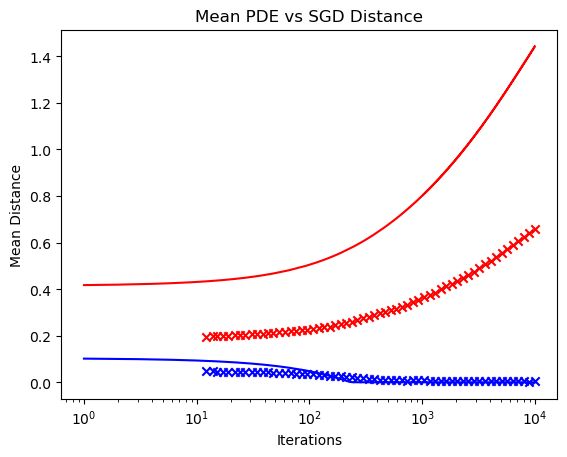

In [116]:
#plot mean distance of network parameters and PDE particles
fig, ax = plt.subplots()
ax.plot(iters, avg_dist_pde_1(iters), c = 'b')
ax.plot(iters, avg_dist_pde_4(iters), c = 'r')
ax.scatter(indices, mean_dist_sgd_1, marker = 'x', c = 'b')
ax.scatter(indices, mean_dist_sgd_4, marker = 'x', c = 'r')
ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean Distance')
ax.set_title('Mean PDE vs SGD Distance')
plt.show()

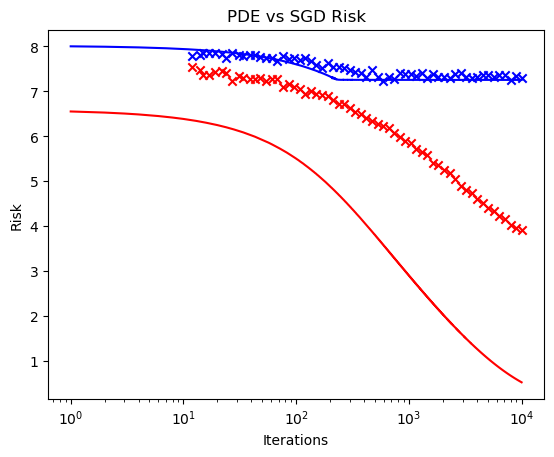

In [117]:
#plot mean risk of network parameters and PDE particles
fig, ax = plt.subplots()
ax.plot(iters, disc_pde_loss_1(iters), c = 'b')
ax.plot(iters, disc_pde_loss_4(iters), c = 'r')
ax.scatter(indices, risk_1, marker = 'x', c = 'b')
ax.scatter(indices, risk_4, marker = 'x', c = 'r')
ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Risk')
ax.set_title('PDE vs SGD Risk')
plt.show()